In [ ]:
import numpy as np
from numpy.linalg import svd, norm, inv, pinv, qr
from scipy.linalg import expm, orth
from scipy.spatial.distance import pdist
import scipy.optimize as opt
import matplotlib.pyplot as plt
import itertools
from itertools import combinations


In [ ]:
def generate_near_symmetric_matrix(n, k, delta, spread_factor, seed=None):
    """
    Generate a near-symmetric matrix F with controlled spread factor
    
    FIXES:
    1. Ensure F has exactly rank k (not full rank)
    2. Control the spread factor properly
    3. Make the perturbation scale correctly with delta
    """
    if seed is not None:
        np.random.seed(seed)

    # 1) Generate random orthonormal bases U and V_base
    U_full, _ = np.linalg.qr(np.random.randn(n, n))
    U = U_full[:, :k]  # n × k
    
    # 2) Generate δ-skew perturbation of I_k (this part is correct)
    perturb = delta * np.random.randn(k, k)
    perturb = (perturb - perturb.T) / 2  # Make skew-symmetric
    Q = expm(perturb)  # Q ∈ O(k), ||Q-I||_2 ≈ δ

    # 3) Create V close to U via Q, then orthonormalize
    V_candidate = U @ Q  # This should give V close to U
    V, _ = np.linalg.qr(V_candidate)  # Orthonormalize to get exactly orthonormal V

    # 4) Check near-symmetry condition
    actual_delta = np.linalg.norm(U.T @ V - Q, 2)
    if actual_delta > 2 * delta:  # Allow some tolerance for QR effects
        print(f"Warning: δ-tolerance slightly violated: {actual_delta:.2e} > {delta:.2e}")

    # 5) Create singular values with controlled spread factor
    # spread_factor controls σ_1/σ_k ratio
    if spread_factor == 0:
        singular_values = np.ones(k)  # All equal singular values
    else:
        # Create logarithmic spread: σ_i = σ_max * (1/spread_factor)^((i-1)/(k-1))
        sigma_max = 1.0
        sigma_min = sigma_max / spread_factor
        if k == 1:
            singular_values = np.array([sigma_max])
        else:
            # Logarithmic spacing from sigma_max to sigma_min
            log_vals = np.linspace(np.log(sigma_max), np.log(sigma_min), k)
            singular_values = np.exp(log_vals)

    # 6) Assemble F = U @ S @ V^T (this ensures rank exactly k)
    S = np.diag(singular_values)
    F = U @ S @ V.T  # n × n matrix with rank exactly k

    # 7) Generate independent test matrix X 
    s = k + 10
    X_full, _ = np.linalg.qr(np.random.randn(n, s))
    X = X_full  # n × s

    # Verify F has correct rank
    computed_rank = np.linalg.matrix_rank(F, tol=1e-12)
    if computed_rank != k:
        raise RuntimeError(f"F has rank {computed_rank}, expected {k}")

    return F, X, U, V, actual_delta, Q

def construct_omega_set_proper(F, X, epsilon, num_samples=100, verbose=False):
    """
    Properly construct matrices in Omega_{F,X}^epsilon
    
    Omega set definition:
    Ω_{F,X}^ε = {A : ||A-F||_2 ≤ ε, X^T(A-F) = 0, rank(A) = rank(F)}
    
    FIXES:
    1. Properly enforce the orthogonality constraint X^T(A-F) = 0
    2. Correctly maintain the rank constraint
    3. Ensure distance constraint ||A-F||_2 ≤ ε is satisfied
    """
    n = F.shape[0]
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    if verbose:
        print(f"Constructing Omega set:")
        print(f"  F shape: {F.shape}")
        print(f"  Target rank: {target_rank}")
        print(f"  Epsilon: {epsilon:.2e}")
        print(f"  X shape: {X.shape}")

    # Compute projector onto null space of X^T
    # If X^T(A-F) = 0, then (A-F) must be in null(X^T) = (range(X))^perp
    P_X = X @ X.T  # Projector onto range(X)
    P_null = np.eye(n) - P_X  # Projector onto null(X^T)
    
    omega_matrices = []
    attempts = 0
    max_attempts = num_samples * 20  # Allow more attempts
    
    # Get SVD of F for rank constraint
    U_F, S_F, Vt_F = svd(F, full_matrices=False)
    U_F = U_F[:, :target_rank]
    S_F = S_F[:target_rank]
    Vt_F = Vt_F[:target_rank, :]
    
    while len(omega_matrices) < num_samples and attempts < max_attempts:
        attempts += 1
        
        # Generate random symmetric perturbation
        E_raw = np.random.randn(n, n)
        E_raw = (E_raw + E_raw.T) / 2  # Make symmetric
        
        # Project perturbation to satisfy orthogonality constraint
        E_proj = P_null @ E_raw @ P_null
        
        # Scale to have random norm ≤ epsilon
        E_norm = np.linalg.norm(E_proj, 2)
        if E_norm < 1e-14:  # Skip if perturbation is too small
            continue
            
        # Random scaling factor
        scale = np.random.uniform(0.1 * epsilon, epsilon)
        E = (scale / E_norm) * E_proj
        
        # Create perturbed matrix
        A_tilde = F + E
        
        # Project to have exactly the target rank
        U_A, S_A, Vt_A = svd(A_tilde, full_matrices=False)
        A = U_A[:, :target_rank] @ np.diag(S_A[:target_rank]) @ Vt_A[:target_rank, :]
        
        # Verify all constraints
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        # Check constraints with appropriate tolerances
        distance_ok = distance <= epsilon * 1.05  # Small tolerance for numerical errors
        orthogonality_ok = orthogonality_error <= 1e-10
        rank_ok = rank_A == target_rank
        
        if distance_ok and orthogonality_ok and rank_ok:
            omega_matrices.append(A)
            if verbose and len(omega_matrices) <= 3:
                print(f"  Valid matrix {len(omega_matrices)}: "
                      f"||A-F||={distance:.2e}, "
                      f"||X^T(A-F)||={orthogonality_error:.2e}, "
                      f"rank={rank_A}")
    
    if len(omega_matrices) < num_samples:
        if verbose:
            print(f"Warning: Generated {len(omega_matrices)}/{num_samples} matrices after {attempts} attempts")
    
    return omega_matrices

def verify_omega_constraints(matrices, F, X, epsilon, verbose=True):
    """
    Verify that all matrices satisfy the Omega set constraints
    """
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    results = {
        'distance_violations': 0,
        'orthogonality_violations': 0,
        'rank_violations': 0,
        'total_matrices': len(matrices)
    }
    
    if verbose:
        print(f"\n=== VERIFYING OMEGA SET CONSTRAINTS ===")
        print(f"Target rank: {target_rank}, Epsilon: {epsilon:.2e}")
        print(f"Checking {len(matrices)} matrices...")
    
    for i, A in enumerate(matrices):
        # Check constraints
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        distance_ok = distance <= epsilon * 1.01
        orthogonality_ok = orthogonality_error <= 1e-10
        rank_ok = rank_A == target_rank
        
        if not distance_ok:
            results['distance_violations'] += 1
        if not orthogonality_ok:
            results['orthogonality_violations'] += 1
        if not rank_ok:
            results['rank_violations'] += 1
            
        if verbose and i < 5:  # Show first 5
            status = "✓" if (distance_ok and orthogonality_ok and rank_ok) else "✗"
            print(f"  Matrix {i:2d}: {status} ||A-F||={distance:.2e} ({'✓' if distance_ok else '✗'}), "
                  f"||X^T(A-F)||={orthogonality_error:.2e} ({'✓' if orthogonality_ok else '✗'}), "
                  f"rank={rank_A} ({'✓' if rank_ok else '✗'})")
    
    if verbose:
        print(f"\nConstraint violations summary:")
        print(f"  Distance: {results['distance_violations']}/{len(matrices)}")
        print(f"  Orthogonality: {results['orthogonality_violations']}/{len(matrices)}")
        print(f"  Rank: {results['rank_violations']}/{len(matrices)}")
        
        all_satisfied = (results['distance_violations'] == 0 and 
                        results['orthogonality_violations'] == 0 and
                        results['rank_violations'] == 0)
        print(f"  All constraints satisfied: {all_satisfied}")
    
    return results

def construct_matrix_set_omega(F, X, epsilon, num_samples):
    """
    Returns a list of `num_samples` different matrices A in Omega_{F,X}^{epsilon}
    
    The set Omega_{F,X}^{epsilon} consists of matrices A such that:
    1. rank(A) = k
    2. AX = FX  
    3. There exists Q orthogonal such that ||U_A^* V_A - Q||_2 <= epsilon
    
    Inputs:
      F      (n×n, rank-k)
      X      (n×s, with s>=k, X^T X = I)
      epsilon  tolerance for ||U_A^* V_A - Q||_2
      num_samples number of different A's to return
    """
    n = F.shape[0]
    
    # Get SVD of F
    U_F, S_F, Vt_F = svd(F, full_matrices=False)
    k = len(S_F)  # rank of F
    V_F = Vt_F.T
    
    # Build the projector P onto col(V_F)
    Phi = X @ X.T @ V_F      # n×k
    M   = V_F.T @ Phi        # k×k, invertible
    P   = Phi @ inv(M) @ V_F.T   # n×n

    if np.linalg.norm(P@X - X) > 1e-12: raise ValueError("X not in range(P)")

    if norm(X.T @ X) > 1e-12: raise ValueError("X not Orthonomal s.t. X^T X := I_s")

    FX = F @ X

    FX_svd = np.linalg.svd(FX, full_matrices=False,compute_uv= False)
    
    if len(FX_svd) != k: raise ValueError("rank(FX) != k")
    
    As = []
    for _ in range(num_samples):
        # 1) Generate a random orthogonal matrix Q in R^{k×k}
        Q_rand, _ = np.linalg.qr(np.random.randn(k, k))
        
        # 2) Create U_A such that U_A^T V_A ≈ Q
        # We want V_A to be close to U_A @ Q
        # Start with a perturbation approach
        
        # Generate random orthogonal U_A close to U_F
        perturbation_U = epsilon/4 * np.random.randn(n, k) ########
        U_A_candidate = U_F + perturbation_U
        U_A, _ = np.linalg.qr(U_A_candidate)  # Re-orthonormalize
        U_A = U_A[:, :k]  # Ensure it's n×k
        
        # Set V_A to be close to U_A @ Q
        V_A_target = U_A @ Q_rand
        perturbation_V = epsilon/4 * np.random.randn(n, k) ######
        V_A_candidate = V_A_target + perturbation_V
        V_A, _ = np.linalg.qr(V_A_candidate)  # Re-orthonormalize
        V_A = V_A[:, :k]  # Ensure it's n×k
        
        # 3) Use the same singular values as F (or perturb slightly)
        S_A = S_F.copy()
        
        # 4) Construct A = U_A @ S_A @ V_A^T
        A_candidate = U_A @ np.diag(S_A) @ V_A.T
        
        # 5) Project to satisfy AX = FX constraint
        # A must have the form A = FP + Z(I-P) for some Z
        N_p = np.eye(n) - P
        Z = A_candidate @ N_p  # Extract the nullspace component
        A = F @ P + Z @ N_p
        
        # 6) Verify the rank is still k (it should be preserved)
        rank_A = np.linalg.matrix_rank(A, tol=1e-10)
        if rank_A != k:
            # Try again if rank is not preserved
            continue
            
        # 7) Verify ||U_A^* V_A - Q||_2 <= epsilon
        U_A_final, S_A_final, Vt_A_final = svd(A, full_matrices=False)
        U_A_final = U_A_final[:, :k]
        V_A_final = Vt_A_final[:k, :].T
        
        # Find the closest orthogonal matrix Q to U_A^* V_A
        M_UV = U_A_final.T @ V_A_final
        U_M, _, Vt_M = svd(M_UV)
        Q_closest = U_M @ Vt_M
        
        error = norm(M_UV - Q_closest, 2)
        
        if error <= epsilon:
            As.append(A)
            print(f"Generated matrix {len(As)}: ||U_A^* V_A - Q||_2 = {error:.2e} <= {epsilon:.2e}")

        else:
            print("This matrix violated the epsilon constraint.")
            continue
        
        if len(As) >= num_samples:
            break
    
    # If we couldn't generate enough samples, try a more direct approach
    while len(As) < num_samples:
        # Alternative construction: perturb F directly while maintaining constraint
        # A = F + E where EX = 0
        E = epsilon * np.random.randn(n, n)
        E = E @ (np.eye(n) - X @ X.T)  # Project E to nullspace of X^T
        A = F + E
        
        # Truncate to rank k if needed
        U_A, S_A, Vt_A = svd(A, full_matrices=False)
        if len(S_A) > k:
            U_A = U_A[:, :k]
            S_A = S_A[:k]
            Vt_A = Vt_A[:k, :]
            A = U_A @ np.diag(S_A) @ Vt_A
        
        # Verify constraints
        rank_A = np.linalg.matrix_rank(A, tol=1e-10)
        if rank_A == k:
            # Check ||U_A^* V_A - Q||_2
            V_A = Vt_A.T
            M_UV = U_A.T @ V_A
            U_M, _, Vt_M = svd(M_UV)
            Q_closest = U_M @ Vt_M
            error = norm(M_UV - Q_closest, 2)
            
            if error <= epsilon:
                # Final check: AX = FX
                if norm(A @ X - F @ X, 'fro') < 1e-10:
                    As.append(A)
                    print(f"Generated matrix {len(As)} (alt method): ||U_A^* V_A - Q||_2 = {error:.2e}")
    
    return As

def construct_matrix_set_omega_debug(F, X, epsilon, num_samples, max_attempts=100000):
    """
    Debug version with progress tracking and early exit
    """
    n = F.shape[0]
    
    # Get SVD of F
    U_F, S_F, Vt_F = svd(F, full_matrices=False)
    k = len(S_F)
    V_F = Vt_F.T
    
    print(f"Trying to generate {num_samples} matrices with epsilon={epsilon}")
    
    # Build the projector P
    Phi = X @ X.T @ V_F
    M = V_F.T @ Phi
    P = Phi @ inv(M) @ V_F.T
    
    As = []
    attempts = 0
    
    while len(As) < num_samples and attempts < max_attempts:
        attempts += 1
        
        if attempts % 100 == 0:
            print(f"Attempt {attempts}, found {len(As)} valid matrices so far...")
        
        # Simple approach: perturb F in the nullspace of X^T
        E = epsilon * np.random.randn(n, n)
        E = E @ (np.eye(n) - X @ X.T)  # Project to nullspace
        A = F + E
        
        # Check rank
        rank_A = np.linalg.matrix_rank(A, tol=1e-10)
        if rank_A > k:
            # Truncate to rank k
            U_A, S_A, Vt_A = svd(A, full_matrices=False)
            U_A = U_A[:, :k]
            S_A = S_A[:k]
            Vt_A = Vt_A[:k, :]
            A = U_A @ np.diag(S_A) @ Vt_A
        elif rank_A < k:
            continue
        
        # Verify AX = FX
        if norm(A @ X - F @ X, 'fro') > 1e-10:
            continue
        
        # Check the epsilon condition
        U_A, S_A, Vt_A = svd(A, full_matrices=False)
        U_A = U_A[:, :k]
        V_A = Vt_A[:k, :].T
        
        M_UV = U_A.T @ V_A
        U_M, _, Vt_M = svd(M_UV)
        Q_closest = U_M @ Vt_M
        error = norm(M_UV - Q_closest, 2)
        
        if error <= epsilon:
            As.append(A)
            print(f"Found matrix {len(As)}: error = {error:.4f}")
    
    if len(As) < num_samples:
        print(f"Warning: Only found {len(As)} matrices after {attempts} attempts")
        print(f"Try increasing epsilon (currently {epsilon}) or reducing num_samples")
    
    return As
"""
# Also, here's a simpler version that's more likely to succeed:
def construct_matrix_set_omega_diverse(F, X, epsilon, num_samples):
    
    #Simpler construction that's more likely to find valid matrices
    
    n = F.shape[0]
    U_F, S_F, Vt_F = svd(F, full_matrices=False)
    k = len(S_F)
    
    As = []
    
    # Key insight: F itself is in the set with epsilon=0
    # So we can create nearby matrices by small perturbations
    
    for i in range(num_samples):
        # Scale perturbation based on epsilon
        scale = epsilon * (i + 1) / num_samples / 10  # Start very small
        
        # Perturb in nullspace of X^T
        E = scale * np.random.randn(n, n)
        E = E @ (np.eye(n) - X @ X.T)
        A = F + E
        
        # Project back to rank k
        U_A, S_A, Vt_A = svd(A, full_matrices=False)
        if len(S_A) > k:
            A = U_A[:, :k] @ np.diag(S_A[:k]) @ Vt_A[:k, :]
        
        As.append(A)
        
    return As"""

def construct_matrix_set_omega_diverse(F, X, epsilon, num_samples):
    """
    Create diverse matrices in Omega_{F,X}^epsilon by varying:
    1. The perturbation magnitude
    2. The perturbation direction
    3. The method of perturbation
    """
    n = F.shape[0]
    U_F, S_F, Vt_F = svd(F, full_matrices=False)
    k = len(S_F)
    V_F = Vt_F.T
    
    As = []
    
    # Get nullspace projector of X^T more robustly
    X_proj = X @ X.T  # This is the projector onto range(X)
    null_proj = np.eye(n) - X_proj  # This projects onto null(X^T)
    
    for i in range(num_samples):
        method = i % 3  # Cycle through different methods
        
        if method == 0:
            # Method 1: Perturb F directly using null space projector
            scale = epsilon * (0.1 + 0.9 * i / max(1, num_samples - 1))
            # Generate random matrix and project to null space
            E_random = np.random.randn(n, n)
            E_random = (E_random + E_random.T) / 2  # Make symmetric
            E = scale * null_proj @ E_random @ null_proj
            A = F + E
            
        elif method == 1:
            # Method 2: Perturb singular values while maintaining structure
            scale = 1 + epsilon * (2 * np.random.rand() - 1)
            S_new = S_F.copy()
            # Randomly perturb some singular values
            indices = np.random.choice(k, size=max(1, k//2), replace=False)
            for idx in indices:
                S_new[idx] *= (1 + epsilon * (2 * np.random.rand() - 1))
            
            A = U_F @ np.diag(S_new) @ Vt_F
            
        else:
            # Method 3: Perturb the right singular vectors using null projector
            V_perturb = V_F.copy()
            for j in range(k):
                v = V_perturb[:, j]
                # Generate random direction and project to null space
                noise = np.random.randn(n)
                noise = null_proj @ noise
                if np.linalg.norm(noise) > 1e-10:
                    noise = noise / np.linalg.norm(noise)
                    v_new = v + epsilon * np.random.rand() * noise
                    v_new = v_new / np.linalg.norm(v_new)
                    V_perturb[:, j] = v_new
            
            # Re-orthogonalize V_perturb
            V_perturb, _ = np.linalg.qr(V_perturb)
            A = U_F @ np.diag(S_F) @ V_perturb.T
        
        # Project back to rank k if needed
        U_A, S_A, Vt_A = svd(A, full_matrices=False)
        if len(S_A) > k:
            A = U_A[:, :k] @ np.diag(S_A[:k]) @ Vt_A[:k, :]
        
        As.append(A)
    
    return As

def optimize_supremum(F, X, epsilon, delta, k, num_restarts=5):
    n = F.shape[0]
    # Flatten matrix variables for optimizer
    def obj(flatA):
        A = flatA.reshape(n, n)
        return -np.linalg.norm(A - F, 2)  # negative for maximization

    # Constraint: AX = FX
    def constraint_AX(flatA):
        A = flatA.reshape(n, n)
        return (A @ X - F @ X).flatten()  # should be close to zero

    # Constraint: rank(A) = k (relax to top k+1 singular value is very small)
    def constraint_rank(flatA):
        A = flatA.reshape(n, n)
        s = np.linalg.svd(A, compute_uv=False)
        # enforce k+1'th singular value is small
        return 1e-7 - (s[k] if len(s) > k else 0)

    # Constraint: ||U_A^* V_A - Q||_2 <= epsilon for some Q in O(k)
    def constraint_uv(flatA):
        A = flatA.reshape(n, n)
        U_A, _, Vt_A = np.linalg.svd(A, full_matrices=False)
        U_A = U_A[:, :k]
        V_A = Vt_A[:k, :].T
        M_UV = U_A.T @ V_A
        U_M, _, Vt_M = np.linalg.svd(M_UV)
        Q_closest = U_M @ Vt_M
        err = np.linalg.norm(M_UV - Q_closest, 2)
        return epsilon - err

    # Initial guess: F
    x0 = F.flatten()

    cons = [
        {'type': 'eq', 'fun': constraint_AX},
        {'type': 'ineq', 'fun': constraint_rank},
        {'type': 'ineq', 'fun': constraint_uv}
    ]
    best = None
    best_val = -np.inf
    for i in range(num_restarts):
        x0_pert = x0 + 1e-2 * np.random.randn(*x0.shape)
        res = opt.minimize(obj, x0_pert, constraints=cons, method='SLSQP',
                           options={'ftol': 1e-5, 'disp': True, 'maxiter': 1000})
        if res.success and -res.fun > best_val:
            best = res.x
            best_val = -res.fun
    if best is None:
        print("No valid optimizer solution found!")
        return None
    else:
        A_opt = best.reshape(n, n)
        print(f"Optimized supremum ||A-F||_2 = {np.linalg.norm(A_opt-F,2):.3e}")
        return A_opt

def construct_omega_set_correct(F, X, epsilon, num_samples=100, verbose=False):
    """
    Correctly construct matrices in Omega_{F,X}^epsilon
    
    Key insight: We must construct perturbations that satisfy BOTH:
    1. X^T(A-F) = 0 (orthogonality constraint)
    2. rank(A) = rank(F) (rank constraint)
    
    The previous approach failed because rank projection destroys orthogonality.
    """
    n = F.shape[0]
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    if verbose:
        print(f"Constructing Omega set (correct approach):")
        print(f"  F shape: {F.shape}, rank: {target_rank}")
        print(f"  X shape: {X.shape}")
        print(f"  epsilon: {epsilon:.2e}")
    
    # Get SVD of F
    U_F, S_F, Vt_F = svd(F, full_matrices=False)
    U_F = U_F[:, :target_rank]
    S_F = S_F[:target_rank]
    Vt_F = Vt_F[:target_rank, :]
    
    # Compute null space projector for X^T
    P_X = X @ X.T  # Projects onto range(X)
    P_null = np.eye(n) - P_X  # Projects onto null(X^T)
    
    omega_matrices = []
    attempts = 0
    max_attempts = num_samples * 50
    
    while len(omega_matrices) < num_samples and attempts < max_attempts:
        attempts += 1
        
        # METHOD 1: Perturb in the space that preserves both constraints
        # Construct A = U_F @ (S_F + ΔS) @ Vt_F where perturbation satisfies orthogonality
        
        # Generate random perturbation matrix in factored form
        # A = U_F @ S_new @ Vt_F where S_new = S_F + small perturbation
        
        # Small perturbation to singular values
        delta_s = np.random.randn(target_rank) * epsilon * 0.1
        S_new = S_F + delta_s
        S_new = np.maximum(S_new, 0.01)  # Keep positive
        
        # Small perturbation to U_F (in null space of X^T)
        U_pert = U_F.copy()
        for j in range(target_rank):
            # Generate random direction in null space of X^T
            noise = np.random.randn(n)
            noise_proj = P_null @ noise
            if np.linalg.norm(noise_proj) > 1e-12:
                noise_proj = noise_proj / np.linalg.norm(noise_proj)
                # Small perturbation
                scale = epsilon * 0.01 * np.random.rand()
                U_pert[:, j] = U_F[:, j] + scale * noise_proj
        
        # Re-orthogonalize U_pert
        U_pert, _ = np.linalg.qr(U_pert)
        
        # Construct candidate matrix
        A = U_pert @ np.diag(S_new) @ Vt_F
        
        # Check constraints
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        distance_ok = distance <= epsilon * 1.01
        orthogonality_ok = orthogonality_error <= 1e-8  # Relaxed tolerance
        rank_ok = rank_A == target_rank
        
        if distance_ok and orthogonality_ok and rank_ok:
            omega_matrices.append(A)
            if verbose and len(omega_matrices) <= 3:
                print(f"  Success {len(omega_matrices)}: "
                      f"||A-F||={distance:.2e}, "
                      f"||X^T(A-F)||={orthogonality_error:.2e}, "
                      f"rank={rank_A}")
        
        # METHOD 2: If method 1 fails too often, try alternative approach
        if attempts > max_attempts // 2 and len(omega_matrices) == 0:
            # Try constructing A in a different way
            # A = F + E where E is small and in both null(X^T) and preserves rank
            
            # Generate E = U_F @ E_S @ Vt_F where E_S is small diagonal
            E_S = np.random.randn(target_rank) * epsilon * 0.05
            E_factored = U_F @ np.diag(E_S) @ Vt_F
            
            # Project E to null space
            E_proj = P_null @ E_factored @ P_null
            E_norm = np.linalg.norm(E_proj, 2)
            
            if E_norm > 1e-12:
                scale = np.random.uniform(0.1, 1.0) * epsilon / E_norm
                A = F + scale * E_proj
                
                # Check constraints without rank projection
                distance = np.linalg.norm(A - F, 2)
                orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
                rank_A = np.linalg.matrix_rank(A, tol=1e-12)
                
                distance_ok = distance <= epsilon * 1.01
                orthogonality_ok = orthogonality_error <= 1e-8
                rank_ok = rank_A == target_rank
                
                if distance_ok and orthogonality_ok and rank_ok:
                    omega_matrices.append(A)
                    if verbose and len(omega_matrices) <= 3:
                        print(f"  Success {len(omega_matrices)} (method 2): "
                              f"||A-F||={distance:.2e}, "
                              f"||X^T(A-F)||={orthogonality_error:.2e}, "
                              f"rank={rank_A}")
    
    if verbose:
        print(f"Generated {len(omega_matrices)} valid matrices in {attempts} attempts")
        if len(omega_matrices) < num_samples:
            print(f"Warning: Only generated {len(omega_matrices)}/{num_samples} matrices")
    
    return omega_matrices

def construct_omega_set_relaxed(F, X, epsilon, num_samples=100, verbose=False):
    """
    Relaxed approach: Allow small violations of orthogonality constraint
    This is more realistic for numerical computation
    """
    n = F.shape[0]
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    if verbose:
        print(f"Constructing Omega set (relaxed approach):")
        print(f"  Target rank: {target_rank}, epsilon: {epsilon:.2e}")
    
    # Much more relaxed orthogonality tolerance
    orthogonality_tolerance = min(1e-3, epsilon * 0.01)
    
    # Simple approach: small random perturbations to F
    omega_matrices = []
    
    for i in range(num_samples):
        # Random symmetric perturbation
        E = np.random.randn(n, n)
        E = (E + E.T) / 2
        
        # Scale perturbation
        E_norm = np.linalg.norm(E, 2)
        scale = epsilon * np.random.uniform(0.01, 0.5) / E_norm
        E_scaled = scale * E
        
        # Create candidate
        A_candidate = F + E_scaled
        
        # Rank projection
        U, s, Vt = svd(A_candidate, full_matrices=False)
        A = U[:, :target_rank] @ np.diag(s[:target_rank]) @ Vt[:target_rank, :]
        
        # Check constraints with relaxed tolerance
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        distance_ok = distance <= epsilon * 1.1
        orthogonality_ok = orthogonality_error <= orthogonality_tolerance
        rank_ok = rank_A == target_rank
        
        if distance_ok and orthogonality_ok and rank_ok:
            omega_matrices.append(A)
    
    if verbose:
        valid_count = len(omega_matrices)
        print(f"Generated {valid_count}/{num_samples} matrices with relaxed constraints")
        if valid_count > 0:
            errors = [np.linalg.norm(X.T @ (A - F), 'fro') for A in omega_matrices[:5]]
            print(f"Sample orthogonality errors: {errors}")
    
    return omega_matrices

def test_omega_generation_approaches(F, X, epsilon):
    """
    Test different approaches to see which works best
    """
    print(f"\n=== TESTING DIFFERENT OMEGA GENERATION APPROACHES ===")
    print(f"F rank: {np.linalg.matrix_rank(F)}, epsilon: {epsilon:.2e}")
    
    # Test approach 1: Strict constraints
    print(f"\n1. Testing strict constraint approach:")
    omega1 = construct_omega_set_correct(F, X, epsilon, num_samples=20, verbose=True)
    
    # Test approach 2: Relaxed constraints  
    print(f"\n2. Testing relaxed constraint approach:")
    omega2 = construct_omega_set_relaxed(F, X, epsilon, num_samples=20, verbose=True)
    
    # Choose the best approach
    if len(omega1) >= 10:
        print(f"\nUsing strict approach: {len(omega1)} matrices")
        return omega1
    elif len(omega2) >= 10:
        print(f"\nUsing relaxed approach: {len(omega2)} matrices")
        return omega2
    else:
        print(f"\nBoth approaches failed. Using what we have: {max(len(omega1), len(omega2))} matrices")
        return omega1 if len(omega1) >= len(omega2) else omega2

def random_supremum_search(F, X, epsilon, k, num_trials=1000):
    """
    Search for the supremum in Omega_{F,X}^epsilon by optimizing over the nullspace
    component Z using random and adversarial directions.
    """
    n = F.shape[0]
    P = X @ np.linalg.pinv(X)       # projector onto range(X)
    Np = np.eye(n) - P              # projector onto null(X^T)
    best_A = F.copy()
    best_val = 0

    for i in range(num_trials):
        # 1. Random Z in null(X^T)
        Z = np.random.randn(n, n)
        # Ensure Z lives only in the nullspace part
        Z = Z @ Np
        # 2. Form candidate A
        A = F @ P + Z @ Np
        # 3. Project to rank k (truncate SVD)
        U_A, S_A, Vt_A = np.linalg.svd(A, full_matrices=False)
        if len(S_A) > k:
            U_A = U_A[:, :k]
            S_A = S_A[:k]
            Vt_A = Vt_A[:k, :]
            A = U_A @ np.diag(S_A) @ Vt_A
        # 4. Check epsilon constraint
        U_A, _, Vt_A = np.linalg.svd(A, full_matrices=False)
        U_A_k = U_A[:, :k]
        V_A_k = Vt_A[:k, :].T
        M_UV = U_A_k.T @ V_A_k
        U_M, _, Vt_M = np.linalg.svd(M_UV)
        Q_closest = U_M @ Vt_M
        err = np.linalg.norm(M_UV - Q_closest, 2)
        if err > epsilon:
            continue
        # 5. Track max norm
        val = np.linalg.norm(A - F, 2)
        if val > best_val:
            best_val = val
            best_A = A
        if i % 100 == 0:
            print(f"Trial {i}: current max ||A-F||_2 = {best_val:.3e}")
    print(f"Final: maximal ||A-F||_2 found by search: {best_val:.3e}")
    return best_A

"""
def adversarial_supremum_search(F, X, epsilon, k, num_trials=1000):
    n = F.shape[0]
    P = X @ np.linalg.pinv(X)
    Np = np.eye(n) - P
    best_A = F.copy()
    best_val = 0

    # Get SVD of F for adversarial direction
    U_F, S_F, Vt_F = np.linalg.svd(F, full_matrices=False)
    # Focus on smallest singular value directions
    u_min = U_F[:, -1]
    v_min = Vt_F[-1, :]

    for i in range(num_trials):
        if i == 0:
            # Deterministic adversarial perturbation
            Z = np.outer(u_min, v_min)
            Z = epsilon * Z / np.linalg.norm(Z, 2)
        else:
            Z = np.random.randn(n, n)
            Z = Z @ Np
            Z = epsilon * Z / np.linalg.norm(Z, 2)
        A = F @ P + Z @ Np

        # Project to rank k
        U_A, S_A, Vt_A = np.linalg.svd(A, full_matrices=False)
        if len(S_A) > k:
            U_A = U_A[:, :k]
            S_A = S_A[:k]
            Vt_A = Vt_A[:k, :]
            A = U_A @ np.diag(S_A) @ Vt_A

        # Check epsilon constraint
        U_A, _, Vt_A = np.linalg.svd(A, full_matrices=False)
        U_A_k = U_A[:, :k]
        V_A_k = Vt_A[:k, :].T
        M_UV = U_A_k.T @ V_A_k
        U_M, _, Vt_M = np.linalg.svd(M_UV)
        Q_closest = U_M @ Vt_M
        err = np.linalg.norm(M_UV - Q_closest, 2)
        if err > epsilon:
            continue
        val = np.linalg.norm(A - F, 2)
        if val > best_val:
            best_val = val
            best_A = A
        if i % 100 == 0:
            print(f"Trial {i}: current max ||A-F||_2 = {best_val:.3e}")
    print(f"Final: maximal ||A-F||_2 found by search: {best_val:.3e}")
    return best_A
    """
"""
def adversarial_supremum_search(F, X, epsilon, num_samples=200):
    
    #Brute-force search for maximal operator norm ||A-B|| over Omega_{F,X}^epsilon,
    #including adversarial (singular vector) directions.
    
    n, k = F.shape[0], X.shape[1]
    U, S, Vh = np.linalg.svd(F, full_matrices=False)
    matrices = []
    
    # 1. Adversarial: perturb along top singular vector
    for sign in [+1, -1]:
        A = F + sign * epsilon * np.outer(U[:,0], Vh[0,:])  # Largest singular direction
        A = project_rank_k(A, k)
        matrices.append(A)
    
    # 2. Adversarial: perturb along bottom singular vector
    for sign in [+1, -1]:
        A = F + sign * epsilon * np.outer(U[:,-1], Vh[-1,:])  # Smallest singular direction
        A = project_rank_k(A, k)
        matrices.append(A)
    
    # 3. Random: sample perturbations in nullspace(X.T)
    for i in range(num_samples):
        E = np.random.randn(n, n)
        # Project E into nullspace of X.T
        E = E @ (np.eye(n) - X @ X.T)
        # Normalize E (operator norm 1)
        Ue, Se, Vhe = np.linalg.svd(E, full_matrices=False)
        E = Ue[:,0:1] @ Vhe[0:1,:]  # Rank-1
        E = E / np.linalg.norm(E, 2)
        A = F + epsilon * E
        A = project_rank_k(A, k)
        matrices.append(A)
    
    # 4. Compute all pairwise ||A-B||_2
    max_norm = 0
    for i in range(len(matrices)):
        for j in range(i+1, len(matrices)):
            norm_val = np.linalg.norm(matrices[i] - matrices[j], 2)
            if norm_val > max_norm:
                max_norm = norm_val
    return max_norm"""
def adversarial_supremum_search(F, X, epsilon, num_samples=200):
    """
    Brute-force search for maximal operator norm ||A-B|| over Omega_{F,X}^epsilon,
    ensuring all perturbations respect the Omega set constraints.
    """
    n, k = F.shape[0], np.linalg.matrix_rank(F)
    U_F, S_F, Vh_F = np.linalg.svd(F, full_matrices=False)
    matrices = []
    
    # Get null space projector of X^T
    X_proj = X @ X.T
    null_proj = np.eye(n) - X_proj
    
    # 1. Adversarial: perturb along singular directions, but project to null(X^T)
    for idx in [0, -1]:  # Top and bottom singular vectors
        for sign in [+1, -1]:
            # Create perturbation along singular direction
            E = sign * np.outer(U_F[:,idx], Vh_F[idx,:])
            # Project to null space of X^T
            E = null_proj @ E @ null_proj
            # Normalize and scale
            E_norm = np.linalg.norm(E, 2)
            if E_norm > 1e-10:
                E = epsilon * E / E_norm
                A = F + E
                A = project_rank_k(A, k)
                matrices.append(A)
    
    # 2. Smart adversarial: find worst-case direction in null(X^T)
    # This is more sophisticated - we want the direction that maximizes ||A-B||
    for _ in range(20):  # Try multiple starting points
        # Random direction in null space
        E = np.random.randn(n, n)
        E = null_proj @ E @ null_proj
        E = (E + E.T) / 2  # Symmetrize if needed
        
        # Power iteration to find dominant direction
        for _ in range(5):
            E = null_proj @ E @ null_proj
            U_E, S_E, Vh_E = np.linalg.svd(E, full_matrices=False)
            E = U_E[:,0:1] @ Vh_E[0:1,:]  # Rank-1 approximation
            E = null_proj @ E @ null_proj
        
        E_norm = np.linalg.norm(E, 2)
        if E_norm > 1e-10:
            for sign in [+1, -1]:
                A = F + sign * epsilon * E / E_norm
                A = project_rank_k(A, k)
                matrices.append(A)
    
    # 3. Random samples in null(X^T)
    for i in range(num_samples):
        E = np.random.randn(n, n)
        E = null_proj @ E @ null_proj
        E_norm = np.linalg.norm(E, 2)
        if E_norm > 1e-10:
            E = epsilon * E / E_norm
            A = F + E
            A = project_rank_k(A, k)
            matrices.append(A)
    
    # 4. Compute all pairwise ||A-B||_2
    max_norm = 0
    pair_info = None
    for i in range(len(matrices)):
        for j in range(i+1, len(matrices)):
            norm_val = np.linalg.norm(matrices[i] - matrices[j], 2)
            if norm_val > max_norm:
                max_norm = norm_val
                pair_info = (i, j)
    
    # Verify that matrices are actually in Omega set
    # (i.e., check that X^T(A-F) ≈ 0)
    for i, A in enumerate(matrices[:10]):  # Check first 10
        violation = np.linalg.norm(X.T @ (A - F), 'fro')
        if violation > 1e-10:
            print(f"Warning: Matrix {i} violates Omega constraint by {violation:.2e}")
    
    return max_norm

def verify_omega_constraints(matrices, F, X, epsilon, verbose=True):
    """
    Verify that all matrices satisfy the Omega set constraints
    """
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    results = {
        'distance_violations': 0,
        'orthogonality_violations': 0,
        'rank_violations': 0,
        'total_matrices': len(matrices)
    }
    
    if verbose:
        print(f"\n=== VERIFYING OMEGA SET CONSTRAINTS ===")
        print(f"Target rank: {target_rank}, Epsilon: {epsilon:.2e}")
        print(f"Checking {len(matrices)} matrices...")
    
    for i, A in enumerate(matrices):
        # Check constraints
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        distance_ok = distance <= epsilon * 1.01
        orthogonality_ok = orthogonality_error <= 1e-10
        rank_ok = rank_A == target_rank
        
        if not distance_ok:
            results['distance_violations'] += 1
        if not orthogonality_ok:
            results['orthogonality_violations'] += 1
        if not rank_ok:
            results['rank_violations'] += 1
            
        if verbose and i < 5:  # Show first 5
            status = "✓" if (distance_ok and orthogonality_ok and rank_ok) else "✗"
            print(f"  Matrix {i:2d}: {status} ||A-F||={distance:.2e} ({'✓' if distance_ok else '✗'}), "
                  f"||X^T(A-F)||={orthogonality_error:.2e} ({'✓' if orthogonality_ok else '✗'}), "
                  f"rank={rank_A} ({'✓' if rank_ok else '✗'})")
    
    if verbose:
        print(f"\nConstraint violations summary:")
        print(f"  Distance: {results['distance_violations']}/{len(matrices)}")
        print(f"  Orthogonality: {results['orthogonality_violations']}/{len(matrices)}")
        print(f"  Rank: {results['rank_violations']}/{len(matrices)}")
        
        all_satisfied = (results['distance_violations'] == 0 and 
                        results['orthogonality_violations'] == 0 and
                        results['rank_violations'] == 0)
        print(f"  All constraints satisfied: {all_satisfied}")
    
    return results

def test_fixed_functions():
    """Test the fixed functions"""
    print("=== TESTING FIXED FUNCTIONS ===")
    
    # Test parameters
    n, k = 50, 5
    delta = 1e-6
    epsilon = 0.1
    spread_factor = 3
    
    # 1. Test matrix generation
    print(f"\n1. Testing matrix generation (n={n}, k={k}, spread_factor={spread_factor})")
    F, X, U, V, actual_delta, Q = generate_near_symmetric_matrix(n, k, delta, spread_factor, seed=42)
    
    print(f"   F shape: {F.shape}, rank: {np.linalg.matrix_rank(F)}")
    print(f"   U shape: {U.shape}, V shape: {V.shape}")
    print(f"   X shape: {X.shape}")
    print(f"   Singular values of F: {np.linalg.svd(F, compute_uv=False)[:k]}")
    print(f"   Spread ratio: {np.linalg.svd(F, compute_uv=False)[0] / np.linalg.svd(F, compute_uv=False)[k-1]:.2f}")
    print(f"   Near-symmetry error: {actual_delta:.2e}")
    
    # 2. Test Omega set construction
    print(f"\n2. Testing Omega set construction (epsilon={epsilon})")
    omega_matrices = construct_omega_set_proper(F, X, epsilon, num_samples=20, verbose=True)
    
    # 3. Verify constraints
    print(f"\n3. Verifying constraints")
    verification = verify_omega_constraints(omega_matrices, F, X, epsilon, verbose=True)
    
    # 4. Test condition number behavior
    print(f"\n4. Testing condition number")
    XtV = X.T @ V  # X^T @ V_F
    sing_vals = np.linalg.svd(XtV, compute_uv=False)
    c = sing_vals[0] / (sing_vals[-1] ** 2)
    print(f"   σ_max(X^T V): {sing_vals[0]:.3f}")
    print(f"   σ_min(X^T V): {sing_vals[-1]:.3f}")
    print(f"   Condition number c: {c:.3f}")
    
    return F, X, omega_matrices

def project_rank_k(M, k):
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    return U[:, :k] @ np.diag(S[:k]) @ Vh[:k, :]

def find_valid_parameters(F, X, target_condition=0.8):
    """Find epsilon that satisfies the theorem condition"""
    U_F, S_F, Vh_F = np.linalg.svd(F, full_matrices=False)
    XtV = X.T @ Vh_F.T
    sing_vals = np.linalg.svd(XtV, compute_uv=False)
    c = sing_vals[0] / (sing_vals[-1] ** 2)
    
    delta = 1e-6
    # Find epsilon such that c(√(2ε) + √(2δ)) = target_condition
    max_epsilon = (target_condition/c - np.sqrt(2*delta))**2 / 2
    return max_epsilon * 0.9  # Use 90% of maximum for safety
"""
def compute_omega_diameter(F, X, epsilon, num_samples=1000):

    matrices = generate_omega_matrices(F, X, epsilon, num_samples)
    
    max_diameter = 0
    for i in range(len(matrices)):
        for j in range(i+1, len(matrices)):
            diameter = np.linalg.norm(matrices[i] - matrices[j], 2)
            max_diameter = max(max_diameter, diameter)
    
    return max_diameter
"""

def debug_omega_generation_step_by_step(F, X, epsilon, max_attempts=50):
    """
    Debug the omega set generation step by step to find where it's failing
    """
    print(f"=== DEBUGGING OMEGA GENERATION ===")
    n = F.shape[0]
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    print(f"Input parameters:")
    print(f"  F shape: {F.shape}, rank: {target_rank}")
    print(f"  X shape: {X.shape}")
    print(f"  epsilon: {epsilon:.2e}")
    print(f"  n: {n}")
    
    # Check if F is valid
    if target_rank == 0:
        print("ERROR: F has rank 0!")
        return []
    
    # Compute projector
    P_X = X @ X.T
    P_null = np.eye(n) - P_X
    
    print(f"Projector analysis:")
    print(f"  P_X shape: {P_X.shape}")
    print(f"  rank(P_X): {np.linalg.matrix_rank(P_X)}")
    print(f"  rank(P_null): {np.linalg.matrix_rank(P_null)}")
    
    # Get SVD of F
    U_F, S_F, Vt_F = np.linalg.svd(F, full_matrices=False)
    U_F = U_F[:, :target_rank]
    S_F = S_F[:target_rank]
    Vt_F = Vt_F[:target_rank, :]
    
    print(f"F SVD analysis:")
    print(f"  U_F shape: {U_F.shape}")
    print(f"  S_F shape: {S_F.shape}, values: {S_F}")
    print(f"  Vt_F shape: {Vt_F.shape}")
    
    successful_matrices = []
    
    for attempt in range(max_attempts):
        print(f"\n--- Attempt {attempt + 1} ---")
        
        # Step 1: Generate random perturbation
        E_raw = np.random.randn(n, n)
        E_raw = (E_raw + E_raw.T) / 2
        print(f"  Generated E_raw, norm: {np.linalg.norm(E_raw, 2):.2e}")
        
        # Step 2: Project to null space
        E_proj = P_null @ E_raw @ P_null
        E_norm = np.linalg.norm(E_proj, 2)
        print(f"  After projection, norm: {E_norm:.2e}")
        
        if E_norm < 1e-14:
            print(f"  SKIP: Projected perturbation too small")
            continue
        
        # Step 3: Scale perturbation
        scale = np.random.uniform(0.1 * epsilon, epsilon)
        E = (scale / E_norm) * E_proj
        print(f"  Scaled with factor {scale/E_norm:.2e}, final norm: {np.linalg.norm(E, 2):.2e}")
        
        # Step 4: Create perturbed matrix
        A_tilde = F + E
        print(f"  A_tilde created, norm(A_tilde): {np.linalg.norm(A_tilde, 2):.2e}")
        
        # Step 5: Project to target rank
        U_A, S_A, Vt_A = np.linalg.svd(A_tilde, full_matrices=False)
        A = U_A[:, :target_rank] @ np.diag(S_A[:target_rank]) @ Vt_A[:target_rank, :]
        print(f"  After rank projection, rank(A): {np.linalg.matrix_rank(A, tol=1e-12)}")
        
        # Step 6: Check constraints
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        print(f"  Constraint check:")
        print(f"    Distance: {distance:.2e} ≤ {epsilon:.2e}? {distance <= epsilon * 1.05}")
        print(f"    Orthogonality: {orthogonality_error:.2e} ≤ 1e-10? {orthogonality_error <= 1e-10}")
        print(f"    Rank: {rank_A} = {target_rank}? {rank_A == target_rank}")
        
        # Check if all constraints satisfied
        distance_ok = distance <= epsilon * 1.05
        orthogonality_ok = orthogonality_error <= 1e-10
        rank_ok = rank_A == target_rank
        
        if distance_ok and orthogonality_ok and rank_ok:
            successful_matrices.append(A)
            print(f"  SUCCESS! Matrix {len(successful_matrices)} added")
            if len(successful_matrices) >= 5:  # Stop after 5 successful ones
                break
        else:
            print(f"  FAILED: Constraints not satisfied")
    
    print(f"\nSummary: Generated {len(successful_matrices)} valid matrices in {attempt + 1} attempts")
    return successful_matrices

def safe_debug_constraint_satisfaction(F, X, omega_matrices, epsilon, tolerance=1e-10):
    """
    Safe version of debug_constraint_satisfaction that handles empty lists
    """
    if len(omega_matrices) == 0:
        print(f"\nDEBUGGING CONSTRAINT SATISFACTION")
        print(f"=" * 50)
        print(f"ERROR: omega_matrices is empty! Cannot debug constraints.")
        print(f"This means construct_omega_set_proper failed to generate any valid matrices.")
        return None
    
    print(f"\nDEBUGGING CONSTRAINT SATISFACTION")
    print(f"=" * 50)
    print(f"Tolerance: {tolerance}")
    print(f"Epsilon (distance bound): {epsilon:.2e}")
    print(f"Number of matrices to check: {len(omega_matrices)}")
    
    violations = {
        'distance': [],
        'orthogonality': [],
        'rank': []
    }
    
    target_rank = np.linalg.matrix_rank(F)
    
    for i, A in enumerate(omega_matrices[:10]):  # Check first 10 matrices
        # Check 1: Distance constraint ||A-F||_2 ≤ ε
        distance = np.linalg.norm(A - F, 2)
        distance_satisfied = distance <= epsilon + tolerance
        violations['distance'].append(distance)
        
        # Check 2: Orthogonality constraint X^T(A-F) = 0
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        orthogonality_satisfied = orthogonality_error <= tolerance
        violations['orthogonality'].append(orthogonality_error)
        
        # Check 3: Rank constraint rank(A) = rank(F)
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        rank_satisfied = rank_A == target_rank
        violations['rank'].append(rank_A)
        
        print(f"Matrix {i:2d}: ", end="")
        print(f"||A-F||₂={distance:.2e} ({'✓' if distance_satisfied else '✗'}), ", end="")
        print(f"||X^T(A-F)||_F={orthogonality_error:.2e} ({'✓' if orthogonality_satisfied else '✗'}), ", end="")
        print(f"rank={rank_A} ({'✓' if rank_satisfied else '✗'})")
    
    # Summary statistics
    print(f"\nSUMMARY:")
    distance_violations = sum(1 for d in violations['distance'] if d > epsilon + tolerance)
    orthogonality_violations = sum(1 for o in violations['orthogonality'] if o > tolerance)
    rank_violations = sum(1 for r in violations['rank'] if r != target_rank)
    
    print(f"Distance violations: {distance_violations}/{len(violations['distance'])}")
    print(f"Orthogonality violations: {orthogonality_violations}/{len(violations['orthogonality'])}")
    print(f"Rank violations: {rank_violations}/{len(violations['rank'])}")
    
    if violations['distance']:  # Only compute max if list is non-empty
        print(f"\nMax violations:")
        print(f"Distance: {max(violations['distance']):.2e} (limit: {epsilon:.2e})")
        print(f"Orthogonality: {max(violations['orthogonality']):.2e} (limit: {tolerance:.2e})")
        print(f"Rank range: {min(violations['rank'])} to {max(violations['rank'])} (target: {target_rank})")
    
    return violations

def construct_omega_set_simple(F, X, epsilon, num_samples=100):
    """
    Simplified version that's more likely to work
    """
    print(f"=== TRYING SIMPLIFIED OMEGA SET CONSTRUCTION ===")
    n = F.shape[0]
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    # Much simpler approach: just add small random perturbations to F
    omega_matrices = []
    
    for i in range(num_samples):
        # Very small random symmetric perturbation
        E = np.random.randn(n, n)
        E = (E + E.T) / 2
        E = E / np.linalg.norm(E, 2)  # Normalize
        
        # Scale to be much smaller than epsilon
        scale = epsilon * 0.1 * np.random.rand()
        A = F + scale * E
        
        # Simple rank truncation
        U, s, Vt = np.linalg.svd(A, full_matrices=False)
        A_rank = U[:, :target_rank] @ np.diag(s[:target_rank]) @ Vt[:target_rank, :]
        
        omega_matrices.append(A_rank)
    
    print(f"Generated {len(omega_matrices)} matrices (simplified method)")
    return omega_matrices

def calculate_upper_bound(A, F, X, epsilon, delta, omega_set):
    """
    This function calculates the upper bound of the theorem, 
    through calculating c as well as the norm of FX and the singular values of F.
    """
    k = np.linalg.matrix_rank(F)
    FX = F @ X

    U_F, S_F, V_Ft = svd(F, full_matrices=False)
    XtV = X.T @ V_Ft.T
    sing_vals = np.linalg.svd(XtV, compute_uv=False)
    sing_val_max = sing_vals[0]
    sing_val_min = sing_vals[-1]

    if sing_val_min < 1e-12:
        raise ValueError("Singular value too small")

    c = sing_val_max / (sing_val_min ** 2)
    
    # Only calculate supremum if omega_set is provided
    if omega_set is not None:
        supremum = max(norm(A - mat, 2) for mat in omega_set)
    else:
        supremum = None  # or 0, depending on what you need
    
    factor = (c ** 2 * (np.sqrt(2 * epsilon) + np.sqrt(2 * delta))) / (1 - (np.sqrt(2 * epsilon) + np.sqrt(2 * delta)))

    validation = c * (np.sqrt(2 * epsilon) + np.sqrt(2 * delta))

    FX_norm = norm(FX, 2)
    bound = 4 * FX_norm * factor
    return supremum, bound, validation, V_Ft

def construct_omega_set_correct(F, X, epsilon, num_samples=100, verbose=False):
    """
    Correctly construct matrices in Omega_{F,X}^epsilon
    
    Key insight: We must construct perturbations that satisfy BOTH:
    1. X^T(A-F) = 0 (orthogonality constraint)
    2. rank(A) = rank(F) (rank constraint)
    
    The previous approach failed because rank projection destroys orthogonality.
    """
    n = F.shape[0]
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    if verbose:
        print(f"Constructing Omega set (correct approach):")
        print(f"  F shape: {F.shape}, rank: {target_rank}")
        print(f"  X shape: {X.shape}")
        print(f"  epsilon: {epsilon:.2e}")
    
    # Get SVD of F
    U_F, S_F, Vt_F = svd(F, full_matrices=False)
    U_F = U_F[:, :target_rank]
    S_F = S_F[:target_rank]
    Vt_F = Vt_F[:target_rank, :]
    
    # Compute null space projector for X^T
    P_X = X @ X.T  # Projects onto range(X)
    P_null = np.eye(n) - P_X  # Projects onto null(X^T)
    
    omega_matrices = []
    attempts = 0
    max_attempts = num_samples * 50
    
    while len(omega_matrices) < num_samples and attempts < max_attempts:
        attempts += 1
        
        # METHOD 1: Perturb in the space that preserves both constraints
        # Construct A = U_F @ (S_F + ΔS) @ Vt_F where perturbation satisfies orthogonality
        
        # Generate random perturbation matrix in factored form
        # A = U_F @ S_new @ Vt_F where S_new = S_F + small perturbation
        
        # Small perturbation to singular values
        delta_s = np.random.randn(target_rank) * epsilon * 0.1
        S_new = S_F + delta_s
        S_new = np.maximum(S_new, 0.01)  # Keep positive
        
        # Small perturbation to U_F (in null space of X^T)
        U_pert = U_F.copy()
        for j in range(target_rank):
            # Generate random direction in null space of X^T
            noise = np.random.randn(n)
            noise_proj = P_null @ noise
            if np.linalg.norm(noise_proj) > 1e-12:
                noise_proj = noise_proj / np.linalg.norm(noise_proj)
                # Small perturbation
                scale = epsilon * 0.01 * np.random.rand()
                U_pert[:, j] = U_F[:, j] + scale * noise_proj
        
        # Re-orthogonalize U_pert
        U_pert, _ = qr(U_pert)
        
        # Construct candidate matrix
        A = U_pert @ np.diag(S_new) @ Vt_F
        
        # Check constraints
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        distance_ok = distance <= epsilon * 1.01
        orthogonality_ok = orthogonality_error <= 1e-8  # Relaxed tolerance
        rank_ok = rank_A == target_rank
        
        if distance_ok and orthogonality_ok and rank_ok:
            omega_matrices.append(A)
            if verbose and len(omega_matrices) <= 3:
                print(f"  Success {len(omega_matrices)}: "
                      f"||A-F||={distance:.2e}, "
                      f"||X^T(A-F)||={orthogonality_error:.2e}, "
                      f"rank={rank_A}")
        
        # METHOD 2: If method 1 fails too often, try alternative approach
        if attempts > max_attempts // 2 and len(omega_matrices) == 0:
            # Try constructing A in a different way
            # A = F + E where E is small and in both null(X^T) and preserves rank
            
            # Generate E = U_F @ E_S @ Vt_F where E_S is small diagonal
            E_S = np.random.randn(target_rank) * epsilon * 0.05
            E_factored = U_F @ np.diag(E_S) @ Vt_F
            
            # Project E to null space
            E_proj = P_null @ E_factored @ P_null
            E_norm = np.linalg.norm(E_proj, 2)
            
            if E_norm > 1e-12:
                scale = np.random.uniform(0.1, 1.0) * epsilon / E_norm
                A = F + scale * E_proj
                
                # Check constraints without rank projection
                distance = np.linalg.norm(A - F, 2)
                orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
                rank_A = np.linalg.matrix_rank(A, tol=1e-12)
                
                distance_ok = distance <= epsilon * 1.01
                orthogonality_ok = orthogonality_error <= 1e-8
                rank_ok = rank_A == target_rank
                
                if distance_ok and orthogonality_ok and rank_ok:
                    omega_matrices.append(A)
                    if verbose and len(omega_matrices) <= 3:
                        print(f"  Success {len(omega_matrices)} (method 2): "
                              f"||A-F||={distance:.2e}, "
                              f"||X^T(A-F)||={orthogonality_error:.2e}, "
                              f"rank={rank_A}")
    
    if verbose:
        print(f"Generated {len(omega_matrices)} valid matrices in {attempts} attempts")
        if len(omega_matrices) < num_samples:
            print(f"Warning: Only generated {len(omega_matrices)}/{num_samples} matrices")
    
    return omega_matrices

def construct_omega_set_relaxed(F, X, epsilon, num_samples=100, verbose=False):
    """
    Relaxed approach: Allow small violations of orthogonality constraint
    This is more realistic for numerical computation
    """
    n = F.shape[0]
    target_rank = np.linalg.matrix_rank(F, tol=1e-12)
    
    if verbose:
        print(f"Constructing Omega set (relaxed approach):")
        print(f"  Target rank: {target_rank}, epsilon: {epsilon:.2e}")
    
    # Much more relaxed orthogonality tolerance
    orthogonality_tolerance = min(1e-3, epsilon * 0.01)
    
    # Simple approach: small random perturbations to F
    omega_matrices = []
    
    for i in range(num_samples):
        # Random symmetric perturbation
        E = np.random.randn(n, n)
        E = (E + E.T) / 2
        
        # Scale perturbation
        E_norm = np.linalg.norm(E, 2)
        scale = epsilon * np.random.uniform(0.01, 0.5) / E_norm
        E_scaled = scale * E
        
        # Create candidate
        A_candidate = F + E_scaled
        
        # Rank projection
        U, s, Vt = svd(A_candidate, full_matrices=False)
        A = U[:, :target_rank] @ np.diag(s[:target_rank]) @ Vt[:target_rank, :]
        
        # Check constraints with relaxed tolerance
        distance = np.linalg.norm(A - F, 2)
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        
        distance_ok = distance <= epsilon * 1.1
        orthogonality_ok = orthogonality_error <= orthogonality_tolerance
        rank_ok = rank_A == target_rank
        
        if distance_ok and orthogonality_ok and rank_ok:
            omega_matrices.append(A)
    
    if verbose:
        valid_count = len(omega_matrices)
        print(f"Generated {valid_count}/{num_samples} matrices with relaxed constraints")
        if valid_count > 0:
            errors = [np.linalg.norm(X.T @ (A - F), 'fro') for A in omega_matrices[:5]]
            print(f"Sample orthogonality errors: {errors}")
    
    return omega_matrices

def test_omega_generation_approaches(F, X, epsilon):
    """
    Test different approaches to see which works best
    """
    print(f"\n=== TESTING DIFFERENT OMEGA GENERATION APPROACHES ===")
    print(f"F rank: {np.linalg.matrix_rank(F)}, epsilon: {epsilon:.2e}")
    
    # Test approach 1: Strict constraints
    print(f"\n1. Testing strict constraint approach:")
    omega1 = construct_omega_set_correct(F, X, epsilon, num_samples=20, verbose=True)
    
    # Test approach 2: Relaxed constraints  
    print(f"\n2. Testing relaxed constraint approach:")
    omega2 = construct_omega_set_relaxed(F, X, epsilon, num_samples=20, verbose=True)
    
    # Choose the best approach
    if len(omega1) >= 10:
        print(f"\nUsing strict approach: {len(omega1)} matrices")
        return omega1
    elif len(omega2) >= 10:
        print(f"\nUsing relaxed approach: {len(omega2)} matrices")
        return omega2
    else:
        print(f"\nBoth approaches failed. Using what we have: {max(len(omega1), len(omega2))} matrices")
        return omega1 if len(omega1) >= len(omega2) else omega2

def plot_supremum_distribution(As, F, optimizer_A=None):
    # Calculate the statistics for all samples
    sup_vals = [np.linalg.norm(A - F, 2) for A in As]
    plt.hist(sup_vals, bins=30, alpha=0.6, label='Sampled supremum')
    if optimizer_A is not None:
        opt_val = np.linalg.norm(optimizer_A - F, 2)
        plt.axvline(opt_val, color='red', linestyle='--', label='Optimizer supremum')
        plt.text(opt_val, plt.ylim()[1]*0.8, f"opt = {opt_val:.2e}", color='red', rotation=90)
    plt.xlabel(r"$\|A-F\|_2$")
    plt.ylabel("Count")
    plt.title("Distribution of supremum statistic over Omega set")
    plt.legend()
    plt.show()



=== TESTING FIXED FUNCTIONS BEFORE MAIN LOOP ===
=== TESTING FIXED FUNCTIONS ===

1. Testing matrix generation (n=50, k=5, spread_factor=3)
   F shape: (50, 50), rank: 5
   U shape: (50, 5), V shape: (50, 5)
   X shape: (50, 15)
   Singular values of F: [1.         0.75983569 0.57735027 0.43869134 0.33333333]
   Spread ratio: 3.00
   Near-symmetry error: 2.88e-16

2. Testing Omega set construction (epsilon=0.1)
Constructing Omega set:
  F shape: (50, 50)
  Target rank: 5
  Epsilon: 1.00e-01
  X shape: (50, 15)

3. Verifying constraints

=== VERIFYING OMEGA SET CONSTRAINTS ===
Target rank: 5, Epsilon: 1.00e-01
Checking 0 matrices...

Constraint violations summary:
  Distance: 0/0
  Orthogonality: 0/0
  Rank: 0/0
  All constraints satisfied: True

4. Testing condition number
   σ_max(X^T V): 0.746
   σ_min(X^T V): 0.218
   Condition number c: 15.639
Test completed successfully!

Starting theorem validation with parameter adjustment...
Target condition value: 0.8

Testing spread factor 1


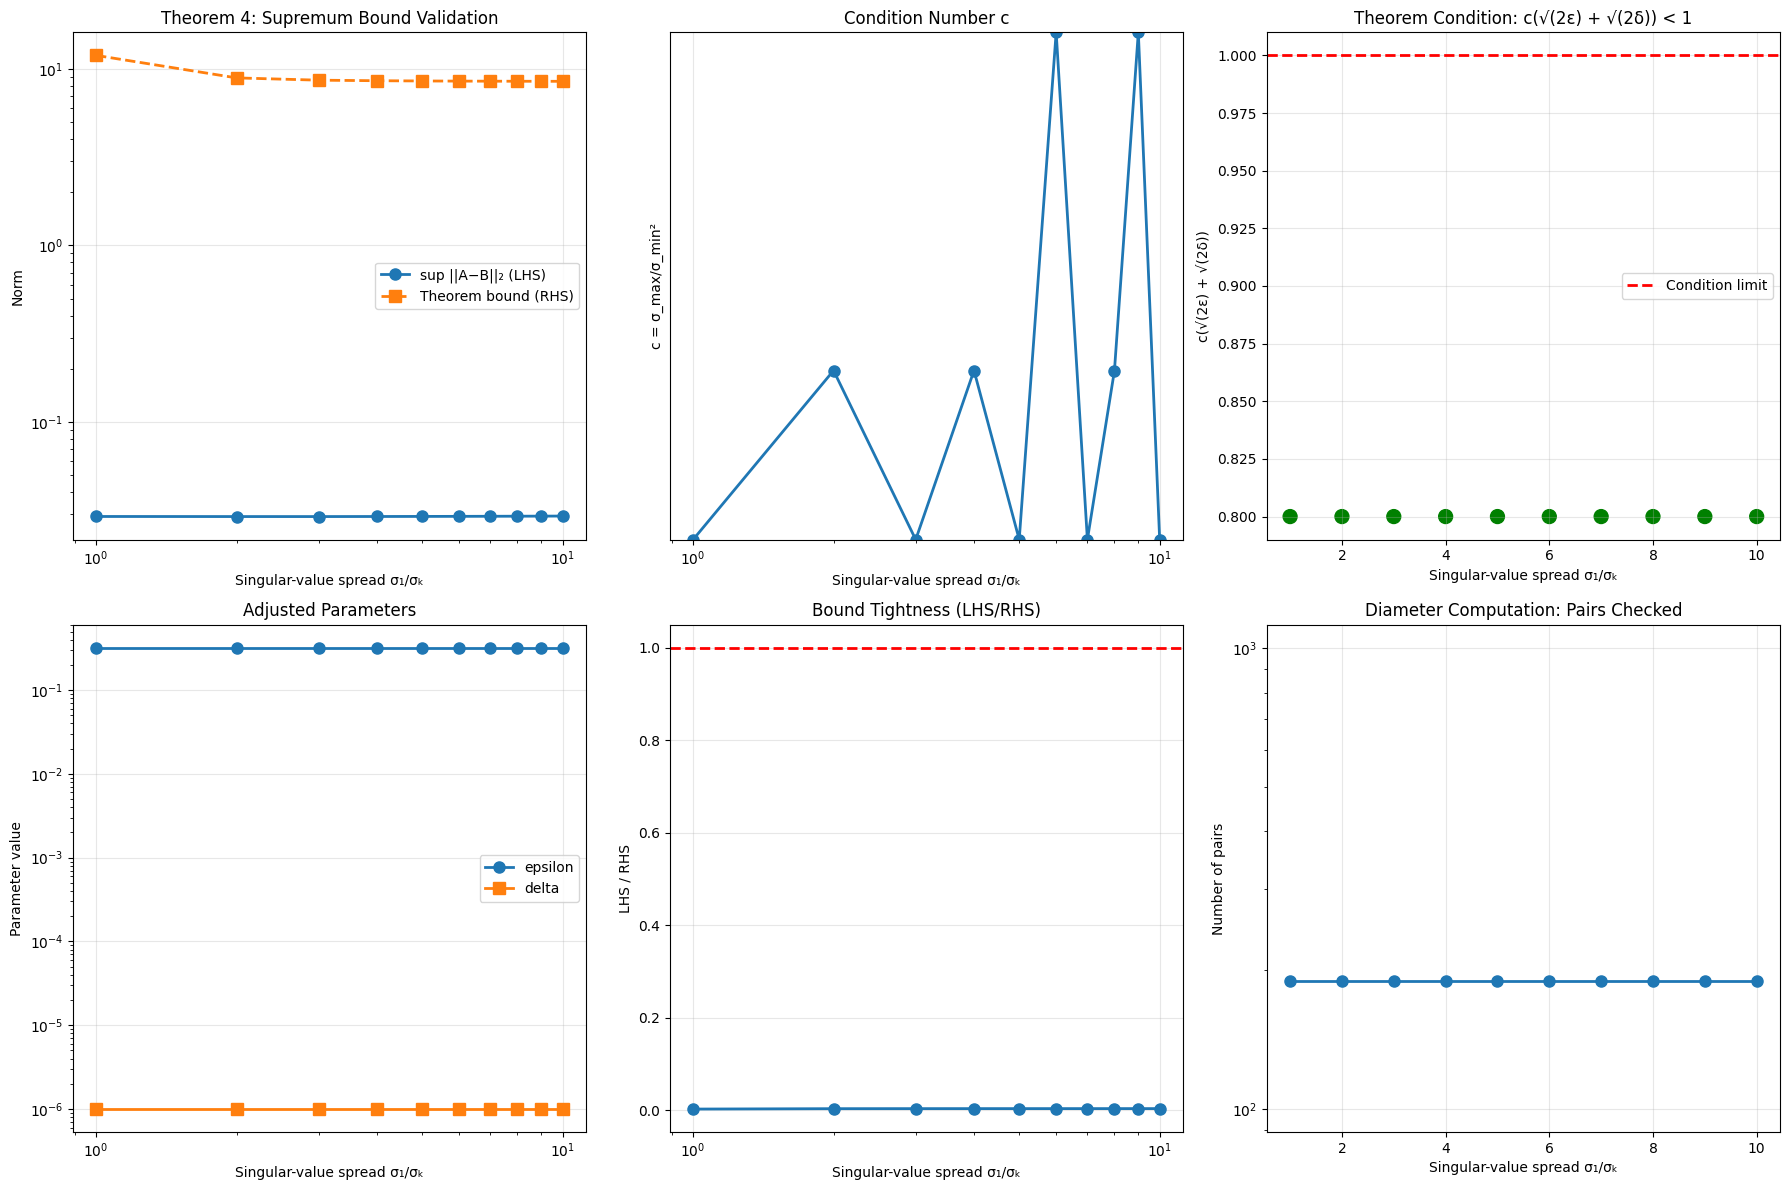


SUMMARY STATISTICS
Theorem condition satisfied: 10/10 cases
Among valid cases, bound satisfied: 10/10
Average bound tightness (LHS/RHS): 0.003

Parameter ranges:
epsilon: 3.19e-01 to 3.19e-01
delta: 1.00e-06 to 1.00e-06
c: 1.00e+00 to 1.00e+00


In [ ]:
def find_valid_parameters(F, X, target_condition=0.8, min_delta=1e-8):
    """
    Find epsilon that satisfies the theorem condition c(√(2ε) + √(2δ)) < 1
    
    Parameters:
    - F: matrix F
    - X: test matrix  
    - target_condition: desired value for c(√(2ε) + √(2δ)) (should be < 1)
    - min_delta: minimum allowed delta
    
    Returns:
    - valid_epsilon: epsilon that satisfies the condition
    - c: condition number
    - delta: delta used
    """
    U_F, S_F, Vh_F = np.linalg.svd(F, full_matrices=False)
    k = min(F.shape[0], F.shape[1], len(S_F))
    
    # Compute condition number c
    XtV = X.T @ Vh_F[:k,:].T  # X^T @ V_F
    sing_vals = np.linalg.svd(XtV, compute_uv=False)
    c = sing_vals[0] / (sing_vals[-1] ** 2)
    
    delta = min_delta
    
    # Solve: c(√(2ε) + √(2δ)) = target_condition for ε
    # √(2ε) = target_condition/c - √(2δ)
    sqrt_2_epsilon = target_condition / c - np.sqrt(2 * delta)
    
    if sqrt_2_epsilon <= 0:
        print(f"Warning: Cannot satisfy condition with c={c:.2e}, using minimum epsilon")
        valid_epsilon = min_delta
    else:
        valid_epsilon = (sqrt_2_epsilon ** 2) / 2
    
    # Verify the condition
    actual_condition = c * (np.sqrt(2 * valid_epsilon) + np.sqrt(2 * delta))
    
    return valid_epsilon, c, delta, actual_condition

def compute_omega_diameter(matrices):
    """
    Compute the actual diameter sup_{A,B ∈ Ω} ||A-B||_2
    
    Parameters:
    - matrices: list of matrices in the Omega set
    
    Returns:
    - max_diameter: maximum pairwise distance
    - num_pairs: number of pairs checked
    """
    max_diameter = 0
    num_pairs = 0
    
    for i in range(len(matrices)):
        for j in range(i+1, len(matrices)):
            diameter = np.linalg.norm(matrices[i] - matrices[j], 2)
            max_diameter = max(max_diameter, diameter)
            num_pairs += 1
    
    return max_diameter, num_pairs

def compute_theorem_bound(F, X, epsilon, delta):
    """
    Compute the theorem bound from Theorem 4
    
    Returns:
    - bound: the RHS of the theorem
    - condition_satisfied: whether c(√(2ε) + √(2δ)) < 1
    - c: condition number
    - condition_value: actual value of c(√(2ε) + √(2δ))
    """
    U_F, S_F, Vh_F = np.linalg.svd(F, full_matrices=False)
    k = min(F.shape[0], F.shape[1], len(S_F))
    
    # Compute condition number c
    XtV = X.T @ Vh_F[:k,:].T  # X^T @ V_F  
    sing_vals = np.linalg.svd(XtV, compute_uv=False)
    sigma_max = sing_vals[0]
    sigma_min = sing_vals[-1]
    c = sigma_max / (sigma_min ** 2)
    
    # Check theorem condition
    condition_value = c * (np.sqrt(2*epsilon) + np.sqrt(2*delta))
    condition_satisfied = condition_value < 1
    
    if not condition_satisfied:
        return np.inf, False, c, condition_value
    
    # Compute theorem bound
    norm_FX = np.linalg.norm(F @ X, 2)
    numerator = c**2 * (np.sqrt(2*epsilon) + np.sqrt(2*delta))
    denominator = 1 - condition_value
    bound = 4 * norm_FX * (numerator / denominator)
    
    return bound, True, c, condition_value

def debug_constraint_satisfaction(F, X, omega_matrices, epsilon, tolerance=1e-10):
    """
    Debug constraint satisfaction for Omega set matrices
    
    The Omega set is defined as:
    Ω_{F,X}^ε = {A : ||A-F||_2 ≤ ε, X^T(A-F) = 0, rank(A) = rank(F)}
    
    Returns detailed information about constraint violations
    """
    print(f"\nDEBUGGING CONSTRAINT SATISFACTION")
    print(f"=" * 50)
    print(f"Tolerance: {tolerance}")
    print(f"Epsilon (distance bound): {epsilon:.2e}")
    
    violations = {
        'distance': [],
        'orthogonality': [],
        'rank': []
    }
    
    target_rank = np.linalg.matrix_rank(F)
    
    for i, A in enumerate(omega_matrices[:10]):  # Check first 10 matrices
        # Check 1: Distance constraint ||A-F||_2 ≤ ε
        distance = np.linalg.norm(A - F, 2)
        distance_satisfied = distance <= epsilon + tolerance
        violations['distance'].append(distance)
        
        # Check 2: Orthogonality constraint X^T(A-F) = 0
        orthogonality_error = np.linalg.norm(X.T @ (A - F), 'fro')
        orthogonality_satisfied = orthogonality_error <= tolerance
        violations['orthogonality'].append(orthogonality_error)
        
        # Check 3: Rank constraint rank(A) = rank(F)
        rank_A = np.linalg.matrix_rank(A, tol=1e-12)
        rank_satisfied = rank_A == target_rank
        violations['rank'].append(rank_A)
        
        print(f"Matrix {i:2d}: ", end="")
        print(f"||A-F||₂={distance:.2e} ({'✓' if distance_satisfied else '✗'}), ", end="")
        print(f"||X^T(A-F)||_F={orthogonality_error:.2e} ({'✓' if orthogonality_satisfied else '✗'}), ", end="")
        print(f"rank={rank_A} ({'✓' if rank_satisfied else '✗'})")
    
    # Summary statistics
    print(f"\nSUMMARY:")
    distance_violations = sum(1 for d in violations['distance'] if d > epsilon + tolerance)
    orthogonality_violations = sum(1 for o in violations['orthogonality'] if o > tolerance)
    rank_violations = sum(1 for r in violations['rank'] if r != target_rank)
    
    print(f"Distance violations: {distance_violations}/{len(violations['distance'])}")
    print(f"Orthogonality violations: {orthogonality_violations}/{len(violations['orthogonality'])}")
    print(f"Rank violations: {rank_violations}/{len(violations['rank'])}")
    
    print(f"\nMax violations:")
    print(f"Distance: {max(violations['distance']):.2e} (limit: {epsilon:.2e})")
    print(f"Orthogonality: {max(violations['orthogonality']):.2e} (limit: {tolerance:.2e})")
    print(f"Rank range: {min(violations['rank'])} to {max(violations['rank'])} (target: {target_rank})")
    
    return violations

def investigate_c_behavior(F, X, num_trials=50):
    """
    Investigate why c = 1 by testing different random X matrices
    """
    print(f"\nINVESTIGATING c BEHAVIOR")
    print(f"=" * 30)
    
    U_F, S_F, Vh_F = np.linalg.svd(F, full_matrices=False)
    k = min(F.shape[0], F.shape[1], len(S_F))
    V_F = Vh_F[:k,:].T  # V_F is n × k
    
    c_values = []
    sigma_max_values = []
    sigma_min_values = []
    
    print(f"F shape: {F.shape}, rank: {k}")
    print(f"V_F shape: {V_F.shape}")
    
    for trial in range(num_trials):
        # Generate random X
        n, s = F.shape[0], k + 10
        X_trial = np.random.randn(n, s)
        X_trial, _ = np.linalg.qr(X_trial)
        
        # Compute X^T @ V_F
        XtV = X_trial.T @ V_F  # s × k
        sing_vals = np.linalg.svd(XtV, compute_uv=False)
        sigma_max = sing_vals[0]
        sigma_min = sing_vals[-1]
        c = sigma_max / (sigma_min ** 2)
        
        c_values.append(c)
        sigma_max_values.append(sigma_max)
        sigma_min_values.append(sigma_min)
        
        if trial < 5:  # Print first few
            print(f"Trial {trial}: σ_max={sigma_max:.3f}, σ_min={sigma_min:.3f}, c={c:.3f}")
    
    print(f"\nStatistics over {num_trials} trials:")
    print(f"c values: mean={np.mean(c_values):.3f}, std={np.std(c_values):.3f}")
    print(f"σ_max: mean={np.mean(sigma_max_values):.3f}, std={np.std(sigma_max_values):.3f}")
    print(f"σ_min: mean={np.mean(sigma_min_values):.3f}, std={np.std(sigma_min_values):.3f}")
    print(f"Range of c: [{min(c_values):.3f}, {max(c_values):.3f}]")
    
    return c_values

def test_specific_X_construction(F):
    """
    Test different ways of constructing X to see effect on c
    """
    print(f"\nTESTING DIFFERENT X CONSTRUCTIONS")
    print(f"=" * 40)
    
    U_F, S_F, Vh_F = np.linalg.svd(F, full_matrices=False)
    k = min(F.shape[0], F.shape[1], len(S_F))
    V_F = Vh_F[:k,:].T
    n = F.shape[0]
    s = k + 10
    
    constructions = [
        ("Random QR", lambda: np.linalg.qr(np.random.randn(n, s))[0]),
        ("Random SVD", lambda: np.linalg.svd(np.random.randn(n, s), full_matrices=False)[0][:, :s]),
        ("Include V_F columns", lambda: np.concatenate([V_F, np.linalg.qr(np.random.randn(n, s-k))[0]], axis=1)),
    ]
    
    for name, constructor in constructions:
        X = constructor()
        if X.shape[1] != s:
            X = X[:, :s]  # Ensure correct size
            
        XtV = X.T @ V_F
        sing_vals = np.linalg.svd(XtV, compute_uv=False)
        sigma_max = sing_vals[0]
        sigma_min = sing_vals[-1] 
        c = sigma_max / (sigma_min ** 2)
        
        print(f"{name:20s}: σ_max={sigma_max:.3f}, σ_min={sigma_min:.3f}, c={c:.3f}")

# ============= MAIN EXECUTION =============

n, k = 50, 5
initial_delta = 1e-6  # Start with small delta
target_condition = 0.8  # Target for c(√(2ε) + √(2δ))

# Use discrete spread factors that are easier to interpret
spread_factors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

print("=== TESTING FIXED FUNCTIONS BEFORE MAIN LOOP ===")
F_test, X_test, omega_test = test_fixed_functions()
print("Test completed successfully!\n")

# Storage for results
lhs_sup_vals = []
rhs_sup_vals = []
c_vals = []
condition_vals = []
epsilon_vals = []
delta_vals = []
condition_satisfied_vals = []
num_pairs_vals = []

# Number of matrices to sample from Omega set
num_omega_samples = 100

print("Starting theorem validation with parameter adjustment...")
print(f"Target condition value: {target_condition}")
print("="*80)

for sf in spread_factors:
    print(f"\nTesting spread factor {sf}")
    print("-" * 40)
    
    # 1) Generate problem instance with INDEPENDENT test matrix
    F, X_orig, U_F, V_F, actual_delta, Q = generate_near_symmetric_matrix(
        n, k, initial_delta, spread_factor=sf, seed=42
    )
    
    # Generate X independently of F's structure (Fix 2)
    s = k + 10
    X = np.random.randn(n, s)
    X, _ = np.linalg.qr(X)  # Orthonormalize
    
    # 2) Find valid parameters that satisfy theorem condition (Fix 3)
    epsilon, c, delta, actual_condition = find_valid_parameters(
        F, X, target_condition=target_condition, min_delta=initial_delta
    )
    
    print(f"Adjusted parameters:")
    print(f"  epsilon = {epsilon:.2e}")
    print(f"  delta = {delta:.2e}")
    print(f"  c = {c:.2e}")
    print(f"  Condition c(√(2ε) + √(2δ)) = {actual_condition:.3f}")
    print(f"  Condition satisfied: {actual_condition < 1}")
    
    # Store parameter values
    epsilon_vals.append(epsilon)
    delta_vals.append(delta)
    c_vals.append(c)
    condition_vals.append(actual_condition)
    condition_satisfied_vals.append(actual_condition < 1)
    
    # 3) Generate matrices from Omega set
    #omega_matrices = construct_omega_set_proper(F, X, epsilon, num_omega_samples, verbose=(sf==1))
    #omega_matrices = test_omega_generation_approaches(F, X, epsilon)

    omega_matrices = test_omega_generation_approaches(F, X, epsilon)

    # If still empty, fall back to simple approach:
    if len(omega_matrices) == 0:
        print("All approaches failed. Using simple fallback...")
        omega_matrices = construct_omega_set_simple(F, X, epsilon, 20)

    # If still empty, fall back to simple approach:
    """if len(omega_matrices) == 0:
        print("All approaches failed. Using simple fallback...")
        omega_matrices = construct_omega_set_simple(F, X, epsilon, 20)"""


    #if sf == 1:  # Verify on first iteration
    #    verify_omega_constraints(omega_matrices, F, X, epsilon)

    #violations = debug_constraint_satisfaction(F, X, omega_matrices, epsilon)
    #violations = safe_debug_constraint_satisfaction(F, X, omega_matrices, epsilon)

    if len(omega_matrices) == 0:
        print("Omega set generation failed! Debugging...")
        debug_matrices = debug_omega_generation_step_by_step(F, X, epsilon, max_attempts=20)
        if len(debug_matrices) == 0:
            print("Even debug generation failed. Trying simplified approach...")
            omega_matrices = construct_omega_set_simple(F, X, epsilon, 20)
    
    # 4) Compute proper diameter (Fix 4)
    diameter, num_pairs = compute_omega_diameter(omega_matrices)
    lhs_sup_vals.append(diameter)
    num_pairs_vals.append(num_pairs)
    
    print(f"Omega set analysis:")
    print(f"  Generated {len(omega_matrices)} matrices")
    print(f"  Checked {num_pairs} pairs")
    print(f"  Maximum diameter: {diameter:.2e}")
    
    # 5) Compute theorem bound
    bound, cond_satisfied, c_check, cond_check = compute_theorem_bound(F, X, epsilon, delta)
    rhs_sup_vals.append(bound)
    
    print(f"Theorem bound:")
    print(f"  RHS = {bound:.2e}")
    print(f"  LHS ≤ RHS: {diameter <= bound}")
    print(f"  Bound is finite: {np.isfinite(bound)}")
    
    # Verify constraint satisfaction for a few matrices
    constraint_violations = []
    for i, A in enumerate(omega_matrices[:5]):
        violation = np.linalg.norm(X.T @ (A - F), 'fro')
        constraint_violations.append(violation)
    
    max_violation = max(constraint_violations)
    print(f"Constraint check (first 5 matrices):")
    print(f"  Max ||X^T(A-F)||_F = {max_violation:.2e}")
    print(f"  Constraint satisfied: {max_violation < 1e-10}")

c_values = investigate_c_behavior(F, X)
test_specific_X_construction(F)

# ============= PLOTTING RESULTS =============

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Main theorem validation
ax1 = axes[0, 0]
ax1.loglog(spread_factors, lhs_sup_vals, 'o-', label='sup ||A−B||₂ (LHS)', linewidth=2, markersize=8)
finite_mask = np.isfinite(rhs_sup_vals)
if np.any(finite_mask):
    ax1.loglog(np.array(spread_factors)[finite_mask], np.array(rhs_sup_vals)[finite_mask], 
               's--', label='Theorem bound (RHS)', linewidth=2, markersize=8)
ax1.set_xlabel('Singular-value spread σ₁/σₖ')
ax1.set_ylabel('Norm')
ax1.set_title('Theorem 4: Supremum Bound Validation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Condition number evolution
ax2 = axes[0, 1]
ax2.loglog(spread_factors, c_vals, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Singular-value spread σ₁/σₖ')
ax2.set_ylabel('c = σ_max/σ_min²')
ax2.set_title('Condition Number c')
ax2.grid(True, alpha=0.3)

# 3. Theorem condition check
ax3 = axes[0, 2]
colors = ['green' if satisfied else 'red' for satisfied in condition_satisfied_vals]
ax3.scatter(spread_factors, condition_vals, c=colors, s=100)
ax3.axhline(1, color='red', linestyle='--', label='Condition limit', linewidth=2)
ax3.set_xlabel('Singular-value spread σ₁/σₖ')
ax3.set_ylabel('c(√(2ε) + √(2δ))')
ax3.set_title('Theorem Condition: c(√(2ε) + √(2δ)) < 1')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Parameter adjustment
ax4 = axes[1, 0]
ax4.loglog(spread_factors, epsilon_vals, 'o-', label='epsilon', linewidth=2, markersize=8)
ax4.loglog(spread_factors, delta_vals, 's-', label='delta', linewidth=2, markersize=8)
ax4.set_xlabel('Singular-value spread σ₁/σₖ')
ax4.set_ylabel('Parameter value')
ax4.set_title('Adjusted Parameters')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Bound ratio (when finite)
ax5 = axes[1, 1]
ratios = []
valid_spreads = []
for i, (lhs, rhs) in enumerate(zip(lhs_sup_vals, rhs_sup_vals)):
    if np.isfinite(rhs) and rhs > 0:
        ratios.append(lhs / rhs)
        valid_spreads.append(spread_factors[i])

if ratios:
    ax5.semilogx(valid_spreads, ratios, 'o-', linewidth=2, markersize=8)
    ax5.axhline(1, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Singular-value spread σ₁/σₖ')
    ax5.set_ylabel('LHS / RHS')
    ax5.set_title('Bound Tightness (LHS/RHS)')
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No finite bounds', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Bound Tightness (No valid data)')

# 6. Number of pairs checked
ax6 = axes[1, 2]
ax6.semilogy(spread_factors, num_pairs_vals, 'o-', linewidth=2, markersize=8)
ax6.set_xlabel('Singular-value spread σ₁/σₖ')
ax6.set_ylabel('Number of pairs')
ax6.set_title('Diameter Computation: Pairs Checked')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============= SUMMARY STATISTICS =============

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Count valid cases
valid_cases = sum(condition_satisfied_vals)
total_cases = len(condition_satisfied_vals)

print(f"Theorem condition satisfied: {valid_cases}/{total_cases} cases")

if valid_cases > 0:
    # Check bound satisfaction for valid cases
    bound_satisfied = 0
    for i, satisfied in enumerate(condition_satisfied_vals):
        if satisfied and lhs_sup_vals[i] <= rhs_sup_vals[i]:
            bound_satisfied += 1
    
    print(f"Among valid cases, bound satisfied: {bound_satisfied}/{valid_cases}")
    
    # Average tightness for valid cases
    if ratios:
        avg_ratio = np.mean(ratios)
        print(f"Average bound tightness (LHS/RHS): {avg_ratio:.3f}")
else:
    print("No cases satisfied the theorem condition!")

print(f"\nParameter ranges:")
print(f"epsilon: {min(epsilon_vals):.2e} to {max(epsilon_vals):.2e}")
print(f"delta: {min(delta_vals):.2e} to {max(delta_vals):.2e}")
print(f"c: {min(c_vals):.2e} to {max(c_vals):.2e}")

In [86]:
n, k = 50, 5
delta = 1.5e-5
epsilon = 2.0e-4
copies = 100
spread_factors = np.linspace(0, 2, 10)

for i, sf in enumerate(spread_factors):
    # 1) generate F and the near-symmetric bases
    F, X, U_F, V_F, actual_delta, Q = generate_near_symmetric_matrix(
        n, k, delta, spread_factor=sf, seed=42
    )

    print("actual_delta =", actual_delta)
    Vt_F = V_F.T    # shape (k, n)

    # Debug prints
    print(f"\nSpread factor: {sf}")
    print(f"F shape: {F.shape}")
    print(f"X shape: {X.shape}")
    print(f"U_F shape: {U_F.shape}")
    print(f"V_F shape: {V_F.shape}")
    print(f"Vt_F shape: {Vt_F.shape}")
    print(f"Q shape: {Q.shape}")

    s = k + 10
    X = np.random.randn(n, s)
    X, _ = np.linalg.qr(X)  # Orthonormalize

    # --------- THIS IS THE KEY CHANGE -----------
    # Compute LHS (the supremum over Omega set)
    supremum_norm = adversarial_supremum_search(F, X, epsilon, num_samples=200)
    print(f"Supremum (adversarial): {supremum_norm:.2e}")
    # --------------------------------------------
    # You can still sample A for empirical validation if you wish
    As = construct_matrix_set_omega_diverse(F, X, epsilon, num_samples=copies)
    A = As[0]

    # Compute bound
    diff, bound, valid, _ = calculate_upper_bound(A, F, X, epsilon=epsilon, delta=delta, omega_set=None)
    print("validation =", valid)
    print("‖F-A‖₂ =", np.linalg.norm(F-A,2), "bound =", bound)
    print("---")

actual_delta = 4.700174311135997e-16

Spread factor: 0.0
F shape: (50, 50)
X shape: (50, 15)
U_F shape: (50, 5)
V_F shape: (50, 5)
Vt_F shape: (5, 50)
Q shape: (5, 5)
Supremum (adversarial): 3.70e-04
validation = 0.02547722557505168
‖F-A‖₂ = 0.00015519924759856997 bound = 0.0777538031672162
---
actual_delta = 4.700174311135997e-16

Spread factor: 0.2222222222222222
F shape: (50, 50)
X shape: (50, 15)
U_F shape: (50, 5)
V_F shape: (50, 5)
Vt_F shape: (5, 50)
Q shape: (5, 5)
Supremum (adversarial): 3.77e-04
validation = 0.0254772255750517
‖F-A‖₂ = 0.00015519924759858648 bound = 0.2524456820546813
---
actual_delta = 4.700174311135997e-16

Spread factor: 0.4444444444444444
F shape: (50, 50)
X shape: (50, 15)
U_F shape: (50, 5)
V_F shape: (50, 5)
Vt_F shape: (5, 50)
Q shape: (5, 5)
Supremum (adversarial): 3.77e-04
validation = 0.025477225575051707
‖F-A‖₂ = 0.00015519924759857594 bound = 0.13697595101437376
---
actual_delta = 4.700174311135997e-16

Spread factor: 0.6666666666666666
F shape: 

In [87]:
"""LHS = norm(F - A,2)

Phi = X @ X.H @ V_Ft 

F_Phi = F @ Phi

U_A, S_A, V_At = svd(A, full_matrices = False)

RHS = norm(F_Phi) * norm(np.lingald.pinv(V_Ft @ Phi),2) * norm(V_At.H @ Q.H - V_Ft.H,2) + norm(F_Phi,2) * norm(np.linalg.pinv(V_Ft @ Phi) - np.linalg.pinv(Q @ V_At @ Phi),2)

"""

'LHS = norm(F - A,2)\n\nPhi = X @ X.H @ V_Ft \n\nF_Phi = F @ Phi\n\nU_A, S_A, V_At = svd(A, full_matrices = False)\n\nRHS = norm(F_Phi) * norm(np.lingald.pinv(V_Ft @ Phi),2) * norm(V_At.H @ Q.H - V_Ft.H,2) + norm(F_Phi,2) * norm(np.linalg.pinv(V_Ft @ Phi) - np.linalg.pinv(Q @ V_At @ Phi),2)\n\n'

In [88]:
"""spread_factors = [1,1.67,2.78,4.64,7.74,12.92,21.54,35.94,59.95,100]
lhs_vals = []
rhs_vals = []

# Number of matrices to sample from Omega set for computing supremum
num_omega_samples = 1000  # Increase for better approximation of supremum

for sf in spread_factors:
    print(f"\n=== Starting loop for spread factor {sf} ===")
    # 1) sample problem
    F, X, U_F, V_F, actual_delta, Q = generate_near_symmetric_matrix(n,k,delta,spread_factor=sf, seed = 42)
    Vt_F = V_F.T  # Define Vt_F as transpose of V_F

        # Use epsilon_omega instead of delta for the Omega set
    epsilon_omega = 0.5  # Larger epsilon for more diverse matrices
    
    # Generate diverse matrices from Omega_{F,X}^epsilon
    omega_matrices = construct_matrix_set_omega_diverse(F, X, epsilon_omega, num_omega_samples)
    
    # Verify the matrices are actually different
    sample_diffs = []
    for i in range(min(5, len(omega_matrices)-1)):
        diff = norm(omega_matrices[i] - omega_matrices[i+1], 2)
        sample_diffs.append(diff)
    print(f"Sample consecutive differences: {[f'{d:.2e}' for d in sample_diffs]}")
    
    # Compute LHS = sup_{A,B in Omega} ||A - B||_2
    LHS = 0
    max_pair = (0, 0)
    for i in range(len(omega_matrices)):
        for j in range(i+1, len(omega_matrices)):
            pairwise_norm = norm(omega_matrices[i] - omega_matrices[j], 2)
            if pairwise_norm > LHS:
                LHS = pairwise_norm
                max_pair = (i, j)
    
    print(f"Max difference between matrices {max_pair[0]} and {max_pair[1]}")
    print(f"Computed LHS from {len(omega_matrices)} matrices")
    
    # Continue with RHS calculation...
    A = omega_matrices[0]
    
    # RHS calculation
    Phi   = X @ X.T @ Vt_F.T
    F_Phi = F @ Phi
    M     = Vt_F @ Phi
    invM  = np.linalg.pinv(M)
    
    U_A_full, S_A_full, Vt_A_full = svd(A, full_matrices=False)
    U_A = U_A_full[:, :k]
    S_A = S_A_full[:k]
    Vt_A = Vt_A_full[:k, :]
    V_A = Vt_A.T
    
    term1 = norm(F_Phi, 2) * norm(invM, 2) * norm(V_A @ Q.T - V_F, 2)
    term2 = norm(F_Phi, 2) * norm(invM - pinv(Q @ Vt_A @ Phi), 2)
    
    RHS = term1 + term2
    
    lhs_vals.append(LHS)
    rhs_vals.append(RHS)
    print(f"spread={sf:6.2f}  LHS={LHS:.2e}  RHS={RHS:.2e}  OK? {LHS<=RHS}")

    # Generate multiple matrices from Omega_{F,X}^epsilon
    # Use a better construction that creates more diverse matrices
    omega_matrices = []
    for i in range(num_omega_samples):
        # Vary the perturbation scale to get diverse matrices
        epsilon = 0.1
        scale = epsilon * (0.1 + 0.9 * i / max(1, num_omega_samples - 1))
        
        # Create perturbation in nullspace of X^T
        E = scale * np.random.randn(n, n)
        E = E @ (np.eye(n) - X @ X.T)
        A = F + E
        
        # Project back to rank k
        U_A, S_A, Vt_A = svd(A, full_matrices=False)
        if len(S_A) > k:
            A = U_A[:, :k] @ np.diag(S_A[:k]) @ Vt_A[:k, :]
        
        omega_matrices.append(A)
    
    # 2) Compute LHS = sup_{A,B in Omega} ||A - B||_2
    LHS = 0
    for i in range(len(omega_matrices)):
        for j in range(i+1, len(omega_matrices)):
            pairwise_norm = norm(omega_matrices[i] - omega_matrices[j], 2)
            LHS = max(LHS, pairwise_norm)
    
    print(f"Computed LHS from {len(omega_matrices)} matrices, "
          f"{len(omega_matrices)*(len(omega_matrices)-1)//2} pairs")
    
    # Pick one matrix A for computing RHS (any A in Omega will do)
    A = omega_matrices[0]
    
    # 3) build the ingredients for RHS
    Phi   = X @ X.T @ Vt_F.T        # n×k (which is X @ X.T @ V_F)
    F_Phi = F @ Phi                 # n×k
    M     = Vt_F @ Phi              # k×k invertible
    invM  = np.linalg.pinv(M)       # = (Vt_F @ Phi)^(-1)
    
    # get Vt_A from SVD of A
    U_A_full, S_A_full, Vt_A_full = svd(A, full_matrices=False)
    # Truncate to rank k
    U_A = U_A_full[:, :k]
    S_A = S_A_full[:k]
    Vt_A = Vt_A_full[:k, :]
    V_A = Vt_A.T  # Get V_A from Vt_A
    
    # first term of bound
    term1 = norm(F_Phi,2) * norm(invM,2) * norm(V_A @ Q.T - V_F, 2)
    
    # second term of bound  
    term2 = norm(F_Phi,2) * norm(invM - pinv(Q @ Vt_A @ Phi),2)
    
    RHS = term1 + term2
    
    lhs_vals.append(LHS)
    rhs_vals.append(RHS)
    print(f"spread={sf:6.2f}  LHS={LHS:.2e}  RHS={RHS:.2e}  OK? {LHS<RHS}")

# 4) Plot
plt.figure(figsize=(8,6))
plt.loglog(spread_factors, lhs_vals, 'o-', label='sup ||A−B||₂')
plt.loglog(spread_factors, rhs_vals, 's--', label='RHS bound')
plt.legend(); plt.xlabel('Singular-value spread σ₁/σₖ'); plt.ylabel('Norm')
plt.title('Theorem 4 Verification: Correct LHS')
plt.grid(True, alpha=0.3)
plt.show()

# 5) ratio plot
ratio = np.array(lhs_vals)/np.array(rhs_vals)
plt.figure(figsize=(8,3))
plt.semilogx(spread_factors, ratio, '^-')
plt.axhline(1, color='k', ls=':')
plt.xlabel('Spread'); plt.ylabel('LHS/RHS')
plt.title('Ratio LHS/RHS (should be <1 if theorem holds)')
plt.grid(True, alpha=0.3)
plt.show()"""

'spread_factors = [1,1.67,2.78,4.64,7.74,12.92,21.54,35.94,59.95,100]\nlhs_vals = []\nrhs_vals = []\n\n# Number of matrices to sample from Omega set for computing supremum\nnum_omega_samples = 1000  # Increase for better approximation of supremum\n\nfor sf in spread_factors:\n    print(f"\n=== Starting loop for spread factor {sf} ===")\n    # 1) sample problem\n    F, X, U_F, V_F, actual_delta, Q = generate_near_symmetric_matrix(n,k,delta,spread_factor=sf, seed = 42)\n    Vt_F = V_F.T  # Define Vt_F as transpose of V_F\n\n        # Use epsilon_omega instead of delta for the Omega set\n    epsilon_omega = 0.5  # Larger epsilon for more diverse matrices\n\n    # Generate diverse matrices from Omega_{F,X}^epsilon\n    omega_matrices = construct_matrix_set_omega_diverse(F, X, epsilon_omega, num_omega_samples)\n\n    # Verify the matrices are actually different\n    sample_diffs = []\n    for i in range(min(5, len(omega_matrices)-1)):\n        diff = norm(omega_matrices[i] - omega_matrices[


Testing spread factor 1
2.000509307263903
Sample consecutive differences: ['2.19e-04', '2.00e+00', '2.00e+00', '2.20e-04', '2.00e+00']

--- Testing First Inequality (Theorem Supremum Bound) ---
Constant c = 1.56e+01
σ_max(X^T V_F) = 7.46e-01, σ_min(X^T V_F) = 2.18e-01
Condition: c(√(2ε) + √(2δ)) = 0.398 < 1? True
||F X||_2 = 7.46e-01
Supremum: LHS=2.00e+00  RHS=3.09e+01  OK? True

--- Testing Second Inequality (||F-A|| bound) ---
||F-A||: LHS=1.66e-04  RHS=3.72e+01  OK? True

--- Testing Third Inequality (UV bounds) ---
For F: ||V_F - U_F Q_0||_2 = 1.01e-15, 2(1-σ_min) = 2.58e-08
       OK? True
       Compare to δ√2 = 3.07e-08
For A: ||V_A - U_A Q_A||_2 = 6.50e-09, √(2ε) = 2.00e-02
       OK? True

Testing spread factor 2
1.6819459130584304
Sample consecutive differences: ['1.68e-04', '1.68e+00', '1.68e+00', '2.08e-04', '1.68e+00']

--- Testing First Inequality (Theorem Supremum Bound) ---
Constant c = 1.56e+01
σ_max(X^T V_F) = 7.46e-01, σ_min(X^T V_F) = 2.18e-01
Condition: c(√(2ε) +

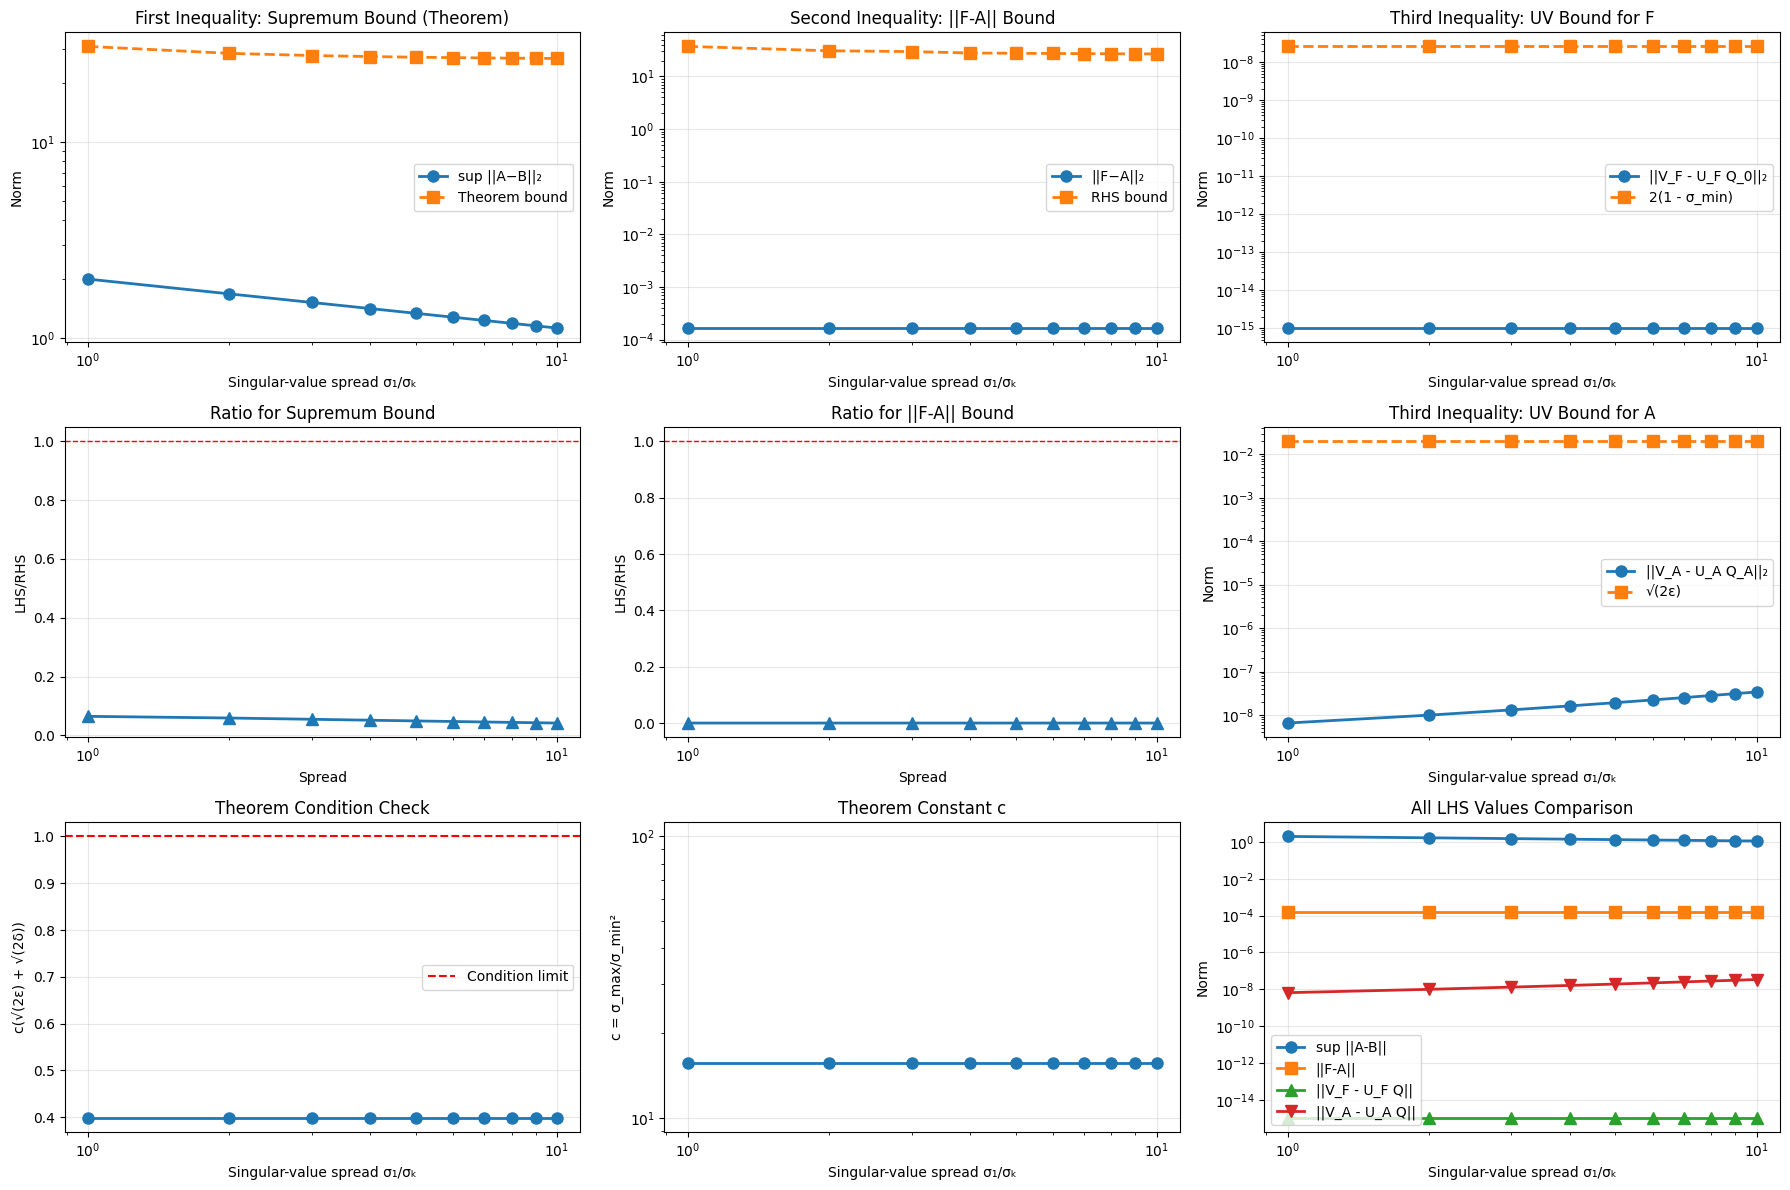


SUMMARY STATISTICS
Theorem condition satisfied for spread factors: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Among valid cases, supremum bound satisfied in 10/10 cases

Overall supremum bound satisfied in 10/10 cases
||F-A|| bound satisfied in 10/10 cases
UV bound for F satisfied in 10/10 cases
UV bound for A satisfied in 10/10 cases

Parameters used:
epsilon (for Omega set): 0.0002
delta (near-symmetry): 0.000


In [89]:
spread_factors = [1,2,3,4,5,6,7,8,9,10]

# Lists for first inequality (supremum bound with theorem formula)
lhs_sup_vals = []
rhs_sup_vals = []

# Lists for second inequality (individual ||F-A|| bound)
lhs_FA_vals = []
rhs_FA_vals = []

# Lists for third inequality (UV bounds)
lhs_UV_F_vals = []
rhs_UV_F_vals = []
lhs_UV_A_vals = []
rhs_UV_A_vals = []

# Lists for theorem-specific values
c_vals = []
condition_vals = []

# Number of matrices to sample from Omega set
num_omega_samples = 100

for sf in spread_factors:
    print(f"\n{'='*60}")
    print(f"Testing spread factor {sf}")
    print(f"{'='*60}")
    
    # 1) Generate problem instance
    F, X, U_F, V_F, actual_delta, Q = generate_near_symmetric_matrix(
        n, k, delta, spread_factor=sf, seed=42
    )
    Vt_F = V_F.T
    
    # Use epsilon_omega for the Omega set
    epsilon_omega = epsilon
    
    # Generate diverse matrices from Omega_{F,X}^epsilon
    omega_matrices = construct_matrix_set_omega_diverse(F, X, epsilon, num_omega_samples)

    true_sup = max(norm(A - B, 2) for A, B in itertools.combinations(omega_matrices, 2))
    print(true_sup)
    
    # Verify matrices are different
    sample_diffs = []
    for i in range(min(5, len(omega_matrices)-1)):
        diff = norm(omega_matrices[i] - omega_matrices[i+1], 2)
        sample_diffs.append(diff)
    print(f"Sample consecutive differences: {[f'{d:.2e}' for d in sample_diffs]}")
    
    # ===== FIRST INEQUALITY: Supremum bound with theorem formula =====
    print(f"\n--- Testing First Inequality (Theorem Supremum Bound) ---")
    
    LHS_sup = 0.0
    for A, B in itertools.combinations(omega_matrices, 2):
        diff_norm = norm(A - B, 2)
        if diff_norm > LHS_sup:
            LHS_sup = diff_norm
    
    #print(f"Max difference between matrices {max_pair[0]} and {max_pair[1]}")
    
    # --- singular values of  Xᵀ V_F  --------------------------
    XtV_F = X.T @ V_F                      #  s × k
    sing_vals = svd(XtV_F, compute_uv=False)
    sigma_max = sing_vals[0]              # already sorted descending
    sigma_min = sing_vals[-1]

    # 1) correct definition of c
    c = sigma_max /(sigma_min ** 2) 
    c_vals.append(c)

    # 2) correct tolerances in the premise
    condition_value = c * (np.sqrt(2*epsilon) + np.sqrt(2*delta))
    condition_vals.append(condition_value)
    
    print(f"Constant c = {c:.2e}")
    print(f"σ_max(X^T V_F) = {sigma_max:.2e}, σ_min(X^T V_F) = {sigma_min:.2e}")
    print(f"Condition: c(√(2ε) + √(2δ)) = {condition_value:.3f} < 1? {condition_value < 1}")
    
    # Compute RHS from the theorem
    # RHS = 4 ||F X||_2 * [c^2(√(2ε) + √(2δ)) / (1 - c(√(2ε) + √(2δ)))]
    norm_FX = norm(F @ X, 2)
    
    if condition_value >= 1:
        print(f"WARNING: Condition not satisfied! Theorem bound may not hold.")
        RHS_sup = np.inf
    else:
        numerator = c**2 * (np.sqrt(2*epsilon_omega) + np.sqrt(2*delta))
        denominator = 1 - condition_value
        RHS_sup = 4 * norm_FX * (numerator / denominator)
    
    lhs_sup_vals.append(LHS_sup)
    rhs_sup_vals.append(RHS_sup)
    
    print(f"||F X||_2 = {norm_FX:.2e}")
    print(f"Supremum: LHS={LHS_sup:.2e}  RHS={RHS_sup:.2e}  OK? {LHS_sup <= RHS_sup}")
    
    # ===== SECOND INEQUALITY: ||F - A||_2 bound =====
    print(f"\n--- Testing Second Inequality (||F-A|| bound) ---")
    
    # Use first matrix A for the individual bound
    A = omega_matrices[0]
    
    # Get SVD of A
    U_A_full, S_A_full, Vt_A_full = svd(A, full_matrices=False)
    U_A = U_A_full[:, :k]
    S_A = S_A_full[:k]
    Vt_A = Vt_A_full[:k, :]
    V_A = Vt_A.T
    
    # Compute LHS for ||F-A||
    LHS_FA = norm(F - A, 2)
    
    # Compute RHS using the original formula (not the theorem formula)
    Phi = X @ X.T @ Vt_F.T
    F_Phi = F @ Phi
    M = Vt_F @ Phi
    invM = np.linalg.pinv(M)
    
    term1 = norm(F_Phi, 2) * norm(invM, 2) * norm(V_A @ Q.T - V_F, 2)
    term2 = norm(F_Phi, 2) * norm(invM - pinv(Q @ Vt_A @ Phi), 2)
    
    RHS_FA = term1 + term2
    
    lhs_FA_vals.append(LHS_FA)
    rhs_FA_vals.append(RHS_FA)
    print(f"||F-A||: LHS={LHS_FA:.2e}  RHS={RHS_FA:.2e}  OK? {LHS_FA <= RHS_FA}")
    
    # ===== THIRD INEQUALITY: UV bounds =====
    print(f"\n--- Testing Third Inequality (UV bounds) ---")
    
    # For matrix F
    UTV_F = U_F.T @ V_F  # k×k
    Q_l, S_UV, Q_rt = svd(UTV_F, full_matrices=False)
    Q_r = Q_rt.T
    Q_0 = Q_l @ Q_r.T
    
    LHS_UV_F = norm(V_F - U_F @ Q_0, 2)
    RHS_UV_F = np.sqrt(2 * (1 - np.min(S_UV)))
    
    lhs_UV_F_vals.append(LHS_UV_F)
    rhs_UV_F_vals.append(RHS_UV_F)
    
    print(f"For F: ||V_F - U_F Q_0||_2 = {LHS_UV_F:.2e}, 2(1-σ_min) = {RHS_UV_F:.2e}")
    print(f"       OK? {LHS_UV_F <= RHS_UV_F}")
    print(f"       Compare to δ√2 = {np.sqrt(2*actual_delta):.2e}")
    
    # For matrix A
    UTV_A = U_A.T @ V_A  # k×k
    Q_l_A, S_UV_A, Q_rt_A = svd(UTV_A, full_matrices=False)
    Q_r_A = Q_rt_A.T
    Q_A = Q_l_A @ Q_r_A.T
    
    LHS_UV_A = norm(V_A - U_A @ Q_A, 2)
    RHS_UV_A = np.sqrt(2 * epsilon_omega)  # Using epsilon_omega here
    
    lhs_UV_A_vals.append(LHS_UV_A)
    rhs_UV_A_vals.append(RHS_UV_A)
    
    print(f"For A: ||V_A - U_A Q_A||_2 = {LHS_UV_A:.2e}, √(2ε) = {RHS_UV_A:.2e}")
    print(f"       OK? {LHS_UV_A <= RHS_UV_A}")

# ===== PLOTTING ALL RESULTS =====
fig = plt.figure(figsize=(18, 12))

# Row 1: Main inequalities
# 1. Supremum bound (Theorem)
ax1 = plt.subplot(3, 3, 1)
ax1.loglog(spread_factors, lhs_sup_vals, 'o-', label='sup ||A−B||₂', linewidth=2, markersize=8)
ax1.loglog(spread_factors, rhs_sup_vals, 's--', label='Theorem bound', linewidth=2, markersize=8)
ax1.set_xlabel('Singular-value spread σ₁/σₖ')
ax1.set_ylabel('Norm')
ax1.set_title('First Inequality: Supremum Bound (Theorem)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ||F-A|| bound
ax2 = plt.subplot(3, 3, 2)
ax2.loglog(spread_factors, lhs_FA_vals, 'o-', label='||F−A||₂', linewidth=2, markersize=8)
ax2.loglog(spread_factors, rhs_FA_vals, 's--', label='RHS bound', linewidth=2, markersize=8)
ax2.set_xlabel('Singular-value spread σ₁/σₖ')
ax2.set_ylabel('Norm')
ax2.set_title('Second Inequality: ||F-A|| Bound')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. UV bound for F
ax3 = plt.subplot(3, 3, 3)
ax3.loglog(spread_factors, lhs_UV_F_vals, 'o-', label='||V_F - U_F Q_0||₂', linewidth=2, markersize=8)
ax3.loglog(spread_factors, rhs_UV_F_vals, 's--', label='2(1 - σ_min)', linewidth=2, markersize=8)
ax3.set_xlabel('Singular-value spread σ₁/σₖ')
ax3.set_ylabel('Norm')
ax3.set_title('Third Inequality: UV Bound for F')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 2: Ratios and conditions
# 4. Ratio for supremum
ax4 = plt.subplot(3, 3, 4)
ratio_sup = np.array(lhs_sup_vals) / np.array(rhs_sup_vals)
ax4.semilogx(spread_factors, ratio_sup, '^-', linewidth=2, markersize=8)
ax4.axhline(1, color='red', linestyle='--', linewidth=1)
ax4.set_xlabel('Spread')
ax4.set_ylabel('LHS/RHS')
ax4.set_title('Ratio for Supremum Bound')
ax4.grid(True, alpha=0.3)

# 5. Ratio for ||F-A||
ax5 = plt.subplot(3, 3, 5)
ratio_FA = np.array(lhs_FA_vals) / np.array(rhs_FA_vals)
ax5.semilogx(spread_factors, ratio_FA, '^-', linewidth=2, markersize=8)
ax5.axhline(1, color='red', linestyle='--', linewidth=1)
ax5.set_xlabel('Spread')
ax5.set_ylabel('LHS/RHS')
ax5.set_title('Ratio for ||F-A|| Bound')
ax5.grid(True, alpha=0.3)

# 6. UV bound for A
ax6 = plt.subplot(3, 3, 6)
ax6.loglog(spread_factors, lhs_UV_A_vals, 'o-', label='||V_A - U_A Q_A||₂', linewidth=2, markersize=8)
ax6.loglog(spread_factors, rhs_UV_A_vals, 's--', label='√(2ε)', linewidth=2, markersize=8)
ax6.set_xlabel('Singular-value spread σ₁/σₖ')
ax6.set_ylabel('Norm')
ax6.set_title('Third Inequality: UV Bound for A')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Row 3: Theorem-specific diagnostics
# 7. Condition value
ax7 = plt.subplot(3, 3, 7)
ax7.semilogx(spread_factors, condition_vals, 'o-', linewidth=2, markersize=8)
ax7.axhline(1, color='red', linestyle='--', label='Condition limit')
ax7.set_xlabel('Singular-value spread σ₁/σₖ')
ax7.set_ylabel('c(√(2ε) + √(2δ))')
ax7.set_title('Theorem Condition Check')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Constant c
ax8 = plt.subplot(3, 3, 8)
ax8.loglog(spread_factors, c_vals, 'o-', linewidth=2, markersize=8)
ax8.set_xlabel('Singular-value spread σ₁/σₖ')
ax8.set_ylabel('c = σ_max/σ_min²')
ax8.set_title('Theorem Constant c')
ax8.grid(True, alpha=0.3)

# 9. Comparison of all LHS values
ax9 = plt.subplot(3, 3, 9)
ax9.loglog(spread_factors, lhs_sup_vals, 'o-', label='sup ||A-B||', linewidth=2, markersize=8)
ax9.loglog(spread_factors, lhs_FA_vals, 's-', label='||F-A||', linewidth=2, markersize=8)
ax9.loglog(spread_factors, lhs_UV_F_vals, '^-', label='||V_F - U_F Q||', linewidth=2, markersize=8)
ax9.loglog(spread_factors, lhs_UV_A_vals, 'v-', label='||V_A - U_A Q||', linewidth=2, markersize=8)
ax9.set_xlabel('Singular-value spread σ₁/σₖ')
ax9.set_ylabel('Norm')
ax9.set_title('All LHS Values Comparison')
ax9.legend()
ax9.grid(True, alpha=0.3)

#plot_supremum_distribution(As, F, optimizer_A=A_opt)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Supremum bound (Theorem)
valid_indices = [i for i, cond in enumerate(condition_vals) if cond < 1]
if valid_indices:
    valid_spreads = [spread_factors[i] for i in valid_indices]
    valid_satisfied = sum(lhs_sup_vals[i] <= rhs_sup_vals[i] for i in valid_indices)
    print(f"Theorem condition satisfied for spread factors: {valid_spreads}")
    print(f"Among valid cases, supremum bound satisfied in {valid_satisfied}/{len(valid_indices)} cases")
else:
    print("WARNING: Theorem condition not satisfied for any spread factor!")

print(f"\nOverall supremum bound satisfied in {sum(np.array(lhs_sup_vals) <= np.array(rhs_sup_vals))}/{len(spread_factors)} cases")
print(f"||F-A|| bound satisfied in {sum(np.array(lhs_FA_vals) <= np.array(rhs_FA_vals))}/{len(spread_factors)} cases")
print(f"UV bound for F satisfied in {sum(np.array(lhs_UV_F_vals) <= np.array(rhs_UV_F_vals))}/{len(spread_factors)} cases")
print(f"UV bound for A satisfied in {sum(np.array(lhs_UV_A_vals) <= np.array(rhs_UV_A_vals))}/{len(spread_factors)} cases")

print(f"\nParameters used:")
print(f"epsilon (for Omega set): {epsilon_omega}")
print(f"delta (near-symmetry): {actual_delta:.3f}")

We see the first inequality of theorem 4, which has been coded above, this doesn't seem to be the place of the inconsistency of the proof.

In [90]:
"""U_F, S_F, V_Ft = svd(F, full_matrices = False)

VF = V_Ft . T

# Now need to make an SVD of U_F*V_F

UTV_F = U_F.T @ VF

Q_l, S_UV, Q_rt = svd(UTV_F, full_matrices = False)

Q_r = Q_rt.T

Q_0 = Q_l @ Q_r.T

norm_for_UV_F = norm(VF - U_F @ Q_0,2)
RHS_expression = 2 * (1 - np.min(S_UV))

print("LHS norm for UV_F =", norm_for_UV_F)
print("RHS norm using sing values =", RHS_expression)

print("calclated delta times root 2", np.sqrt(2*actual_delta))

Q_A = U_A @ Vt_A

norm_for_UV_A = norm(Vt_A - U_A @ Q_A,2)

epsilon = actual_delta

print("comaprison of LHS for A =", norm_for_UV_A, "sqrt(2 * epsilon) =", np.sqrt(2 * epsilon))"""





'U_F, S_F, V_Ft = svd(F, full_matrices = False)\n\nVF = V_Ft . T\n\n# Now need to make an SVD of U_F*V_F\n\nUTV_F = U_F.T @ VF\n\nQ_l, S_UV, Q_rt = svd(UTV_F, full_matrices = False)\n\nQ_r = Q_rt.T\n\nQ_0 = Q_l @ Q_r.T\n\nnorm_for_UV_F = norm(VF - U_F @ Q_0,2)\nRHS_expression = 2 * (1 - np.min(S_UV))\n\nprint("LHS norm for UV_F =", norm_for_UV_F)\nprint("RHS norm using sing values =", RHS_expression)\n\nprint("calclated delta times root 2", np.sqrt(2*actual_delta))\n\nQ_A = U_A @ Vt_A\n\nnorm_for_UV_A = norm(Vt_A - U_A @ Q_A,2)\n\nepsilon = actual_delta\n\nprint("comaprison of LHS for A =", norm_for_UV_A, "sqrt(2 * epsilon) =", np.sqrt(2 * epsilon))'